In [1]:
import pandas as pd
import numpy as np
import re
import string
from flashtext import KeywordProcessor
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, GRU, Dropout, MaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
import tensorflow as tf
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
# This will allow you to see all column names & rows when you are doing .head(). None of the column name will be truncated.
# source: https://stackoverflow.com/questions/49188960/how-to-show-all-of-columns-name-on-pandas-dataframe

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

In [4]:
# Function which plays a beep of given duration and frequency.
# Useful for when executing things that need a while to finish, to get notified.
import os
def beep(duration = 1, freq = 1500):
    """ play tone of duration in seconds and freq in Hz. """
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [4]:
train = pd.read_csv('../data/train.csv',usecols=["id", "keyword", "text", "target"],dtype={'id':'int32','target':'int8'})
test = pd.read_csv('../data/test.csv',usecols=["id", "keyword", "text"],dtype={'id':'int32'})
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [5]:
train.keyword.fillna('other',inplace=True)

# quito el numero 20 que aparece en la keyword
train.loc[:,'keyword'] = train['keyword'].apply(lambda s: re.sub('20', ' ', s))

In [6]:
test.keyword.fillna('other',inplace=True)

# quito el numero 20 que aparece en la keyword
test.loc[:,'keyword'] = train['keyword'].apply(lambda s: re.sub('20', ' ', s))

In [7]:
train.text = train.text.astype(str)
train.keyword = train.keyword.astype(str)

In [8]:
test.text = test.text.astype(str)
test.keyword = test.keyword.astype(str)

In [9]:
#traduzco los pocos casos que no estaban en ingles
train.text = train.text.str.replace('Acesse nosso site para ouvir','Visit our website to listen')
train.text = train.text.str.replace('quem lembra','who remembers')
train.text = train.text.str.replace('Sismo DETECTADO','Earthquake DETECTED')

# Agregamos features que ya hemos creado para analisis de tp1

## Features numericos

In [10]:
def get_list_length(x):
    return len(x)

In [11]:
def to_lowercase(x):
    return x.lower()

In [12]:
def extract_hashtags(x):
    return re.findall(r'#\w+', x)

In [13]:
def extract_tags(x):
    return re.findall(r'@\w+', x)

In [14]:
def extract_links(x):
    return re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)

In [15]:
def create_peculiar_features_before_cleaning(df, pos):
    df_temp = df.copy()
    
    #tags
    df_temp['tags'] = df_temp['text'].apply(extract_tags)
    df.insert(loc=df.shape[1] - pos, column='tags_count', value = df_temp['tags'].apply(get_list_length))
    
    #links
    df_temp['links'] = df_temp['text'].apply(extract_links)
    df.insert(loc=df.shape[1] - pos, column='links_count', value = df_temp['links'].apply(get_list_length))
    
    #hashtags
    df_temp['text'] = df_temp['text'].apply(to_lowercase)
    df_temp['hashtags'] = df_temp['text'].apply(extract_hashtags)
    df.insert(loc=df.shape[1] - pos, column='hashtags_count', value = df_temp['hashtags'].apply(get_list_length))
    
    del(df_temp)
    
    return df

In [16]:
def create_common_numerical_features_before_cleaning(df,pos):

    # Punctuation count
    df.insert(loc=df.shape[1] - pos, column='punctuation_count', value = \
              df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation])))
    
        # Count of uppercase letters
    df.insert(loc=df.shape[1] - pos, column='caps_count', value=\
              df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper())))

    return df

In [17]:
train = create_peculiar_features_before_cleaning(train,1)
train = create_common_numerical_features_before_cleaning(train,1)

In [18]:
test = create_peculiar_features_before_cleaning(test,0)
test = create_common_numerical_features_before_cleaning(test,0)

## Retweets

In [19]:
mi_lista=[]
mi_lista = list(train['text'])
def encuentra_RT(tweet): 
        count = 0
        for i in mi_lista:
            if i==tweet:
                count +=1
            if count >= 2:
                return 1
        else:
            return 0

train.insert(loc=train.shape[1] - 1, column='retweet_bool', value = 0)
train['retweet_bool'] = train['text'].map(encuentra_RT)

In [20]:
mi_lista=[]
mi_lista = list(test['text'])

test.insert(loc=test.shape[1], column='retweet_bool', value = 0)
test['retweet_bool'] = test['text'].map(encuentra_RT)

## Limpio texto

In [21]:
train['text'] = train['text'].apply(to_lowercase)
test['text'] = test['text'].apply(to_lowercase)

In [22]:
def remove_hashtags(text):
    return re.sub(r'#', '',text)

In [23]:
def remove_tags(text):
    return re.sub(r'@', '', text)

In [24]:
train['text'] = train['text'].apply(lambda x : remove_hashtags(x))
train['text'] = train['text'].apply(lambda x : remove_tags(x))

In [25]:
test['text'] = test['text'].apply(lambda x : remove_hashtags(x))
test['text'] = test['text'].apply(lambda x : remove_tags(x))

In [26]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [27]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [28]:
def remove_emoticons(text):
    emoticons_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoticons_pattern.sub(r'', text)

In [29]:
def clean_text(text):
    
    # Remove line breaks
    text = re.sub(r'\n',' ', text) 
    
    # Remove leading, trailing, and extra spaces
    text = re.sub('\s+', ' ', text).strip() 
    
    #annoying characters
    text = re.sub(r"å_", "", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"Ì©", "", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"åÀ", "", text)
    
    # emoticons
    text = remove_emoticons(text)
    
    #URL
    text = remove_URL(text)
    
    #html
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)
    text = remove_html(text)
    
    return text

In [30]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [31]:
contractions_dict = { 
    "it's": 'it is',
    "how'd": 'how did',
    "where'd": 'where did',
    "ain't": 'am not',
    "they'll": 'they will',
    "who's": 'who is',
    "'cause": 'because',
    "wouldn't": 'would not',
    "i'm": 'i am',
    "aren't": 'are not',
    "i'll": 'i will',
    "might've": 'might have',
    "you're": 'you are',
    "mightn't": 'might not',
    "shouldn't": 'should not',
    "he's": 'he is',
    "didn't": 'did not',
    "he'd've": 'he would have',
    "i'd": 'i would',
    "there's": 'there is',
    "we'd": 'we would',
    "what's": 'what is',
    "must've": 'must have',
    "they'd": 'they would',
    "who'll": 'who will',
    "what'll": 'what will',
    "isn't": 'is not',
    "ma'am": 'madam',
    "let's": 'let us',
    "should've": 'should have',
    "that'd": 'that would',
    "she'd": 'she would',
    "we've": 'we have',
    "can't've": 'cannot have',
    "how'll": 'how will',
    "we'll": 'we will',
    "what're": 'what are',
    "couldn't've": 'could not have',
    "it'll": 'it will',
    "they're": 'they are',
    "wasn't": 'was not',
    "you'll": 'you will',
    "haven't": 'have not',
    "she's": 'she is',
    "don't": 'do not',
    "there'd": 'there had',
    "hasn't": 'has not',
    "needn't": 'need not',
    "he'd": 'he would',
    "you'd": 'you would',
    "oughtn't": 'ought not',
    "sha'n't": 'shall not',
    "won't": 'will not',
    "they've": 'they have',
    "it'd": 'it would',
    "shan't": 'shall not',
    "mustn't": 'must not',
    "he'll": 'he will',
    'thx': 'thanks',
    "mayn't": 'may not',
    "doesn't": 'does not',
    "how's": 'how is',
    "can't": 'cannot',
    "couldn't": 'could not',
    "that's": 'that is',
    "what've": 'what have',
    "hadn't've": 'had not have',
    "weren't": 'were not',
    "hadn't": 'had not',
    "she'll": 'she will',
    "i've": 'i have',
    "where's": 'where is',
    "we're": 'we are',
    "could've": 'could have'
}

In [32]:
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [33]:
train['text'] = train['text'].apply(lambda x : expand_contractions(x))
test['text'] = test['text'].apply(lambda x : expand_contractions(x))

In [34]:
def replace_repeated_char(string, char): 
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string 

In [35]:
def replace_repeated_special_vowel_char(string, char): 
    pattern = char + '{3,}'
    string = re.sub(pattern, char + char, string)
    return string 

In [36]:
#son menos probables de repetirse
train['text'] = train['text'].apply(lambda x: replace_repeated_char(x,'a'))
train['text'] = train['text'].apply(lambda x: replace_repeated_char(x,'u'))

#pueden repetirse como por ejemplo cool o skiing 
train['text'] = train['text'].apply(lambda x: replace_repeated_special_vowel_char(x,'e'))
train['text'] = train['text'].apply(lambda x: replace_repeated_special_vowel_char(x,'i'))
train['text'] = train['text'].apply(lambda x: replace_repeated_special_vowel_char(x,'o'))

In [37]:
#son menos probables de repetirse
test['text'] = test['text'].apply(lambda x: replace_repeated_char(x,'a'))
test['text'] = test['text'].apply(lambda x: replace_repeated_char(x,'u'))

#pueden repetirse como por ejemplo cool o skiing 
test['text'] = test['text'].apply(lambda x: replace_repeated_special_vowel_char(x,'e'))
test['text'] = test['text'].apply(lambda x: replace_repeated_special_vowel_char(x,'i'))
test['text'] = test['text'].apply(lambda x: replace_repeated_special_vowel_char(x,'o'))

In [38]:
def replace_repeated_qm_char(text): 
    return re.sub(r'(\?)(?=\1)', '', text)

In [39]:
def replace_repeated_exclamation_char(text): 
    return re.sub(r'(!)(?=\1)', '', text)

In [40]:
train['text'] = train['text'].apply(lambda x: replace_repeated_qm_char(x))
train['text'] = train['text'].apply(lambda x: replace_repeated_exclamation_char(x))

In [41]:
test['text'] = test['text'].apply(lambda x: replace_repeated_qm_char(x))
test['text'] = test['text'].apply(lambda x: replace_repeated_exclamation_char(x))

In [42]:
abreviaciones_dict = {
    'tbsp': 'tablespooful',
    'omdb': 'over my dead body',
    'lmfao': 'laugh my fucking ass off',
    'poc': 'people of color',
    'tmb': 'tweet me back',
    'ayor': 'at your own risk',
    'b+b': 'bed and breakfast',
    'idgaf': 'i do not give a fuck',
    'bros': 'brothers',
    'w8': 'wait',
    'imho': 'in my humble opinion',
    'jsyk': 'just so you know',
    'e123': 'easy as one two three',
    'mfw': 'my face when',
    'ltd': 'limited',
    'wassup': 'what is up',
    'afair': 'as far as i remember',
    'rofl': 'rolling on the floor laughing',
    'fc': 'fingers crossed',
    'ptb': 'please text back',
    'etc': 'and so on',
    'b2b': 'business to business',
    'asap': 'as soon as possible',
    'l8r': 'later',
    'ily': 'i love you',
    'ruok': 'are you ok',
    'btw': 'by the way',
    'tldr': 'too long i did not read',
    'ave.': 'avenue',
    'asl': 'age, sex, location',
    'ssdd': 'same stuff different day',
    'pp': 'pages',
    'a3': 'anytime anywhere anyplace',
    'b2c': 'business to customer',
    'nth': 'nice to have',
    'cya': 'see you',
    'mofo': 'motherfucker',
    'thks': 'thank you',
    'ilu': 'i love you',
    'tia': 'thanks in advance',
    'bbl': 'be back later',
    'lbs': 'pounds',
    'idgadf': 'i do not give a damn fuck',
    'fig': 'figure',
    'nfs': 'not for sale',
    'gmt': 'greenwich mean time',
    'nbd': 'not big deal',
    'omw': 'on my way',
    'wb': 'welcome back',
    'jic': 'just in case',
    'nvr': 'never',
    'gg': 'good game',
    'dbmib': 'do not bother me i am busy',
    'rlrt': 'real life retweet',
    'nsfw': 'not safe for work',
    'w/': 'with',
    'roflol': 'rolling on the floor laughing out loud',
    'nrn': 'no reply necessary',
    'nagi': 'not a good idea',
    'wywh': 'wish you were here',
    'utc': 'coordinated universal time',
    'cet': 'central european time',
    'nhs': 'national health service',
    'lb': 'pound',
    'goi': 'get over it',
    'nbc': 'national broadcasting company',
    'zzz': 'sleeping bored and tired',
    'rbtl': 'read between the lines',
    'a.m': 'before midday',
    'p.m': 'after midday',
    'tho': 'though',
    'mfs': 'motherfuckers',
    'omg': 'oh my god',
    'mph': 'miles per hour',
    'tbh': 'to be honest',
    'gmta': 'great minds think alike',
    'ie': 'that is',
    'ppl': 'people',
    'ynk': 'you never know',
    'ic': 'i see',
    'aamof': 'as a matter of fact',
    'embm': 'early morning business meeting',
    'gl': 'good luck',
    'encl.': 'enclosed',
    'ngl': 'not going to lie',
    'aymm': 'are you my mother',
    'icymi': 'in case you missed it',
    'wuf': 'where are you from',
    'ttyl': 'talk to you later',
    'h&c': 'hot and cold',
    'blvd': 'boulevard',
    'sfw': 'safe for work',
    'atk': 'at the keyboard',
    '$': ' dollar ',
    'cyt': 'see you tomorrow',
    'u4e': 'yours for ever',
    'srsly': 'seriously',
    'ibrb': 'i will be right back',
    'ygtr': 'you got that right',
    'b&b': 'bed and breakfast',
    'tbs': 'tablespooful',
    'ft.': 'feet',
    'gps': 'global positioning system',
    'g.o.a.t': 'greatest of all time',
    'irl': 'in real life',
    'p.a': 'per annum',
    'nsfl': 'not safe for life',
    'ftw': 'for the win',
    'fawc': 'for anyone who cares',
    'glhf': 'good luck have fun',
    'bbc': 'british broadcasting corporation',
    '€': ' euro ',
    'gr8': 'great',
    'encl': 'enclosed',
    'oic': 'oh i see',
    'b4': 'before',
    'j4f': 'just for fun',
    'cv': 'curriculum vitae',
    'ht': 'height',
    'apps': 'applications',
    'hr': 'hour',
    'fyi': 'for your information',
    'imo': 'in my opinion',
    'u2': 'you too',
    'diy': 'do it yourself',
    'tfw': 'that feeling when',
    'gyal': 'girl',
    'eet': 'eastern european time',
    '4ao': 'for adults only',
    'gal': 'get a life',
    'wuzup': 'what is up',
    'iow': 'in other words',
    'lol': 'laughing out loud',
    'fimh': 'forever in my heart',
    'jk': 'just kidding',
    'i.e': 'that is',
    'idc': 'i do not care',
    'mte': 'my thoughts exactly',
    'acct': 'account',
    'bae': 'before anyone else',
    'cia': 'central intelligence agency',
    'wtg': 'way to go',
    'app': 'application',
    'pto': 'please turn over',
    'iirc': 'if i remember correctly',
    'bbbg': 'bye bye be good',
    'lmao': 'laugh my ass offremove',
    'gahoy': 'get a hold of yourself',
    'fb': 'facebook',
    'eg': 'example',
    'afk': 'away from keyboard',
    'ltns': 'long time no see',
    'm8': 'mate',
    'fwiw': 'for what it is worth',
    'afaik': 'as far as i know',
    'bsaaw': 'big smile and a wink',
    'til': 'today i learned',
    'afaic': 'as far as i am concerned',
    'afaict': 'as far as i can tell',
    'bak': 'back at keyboard',
    'ldr': 'long distance relationship',
    'mrw': 'my reaction when',
    'g9': 'genius',
    'nyc': 'new york city',
    'dae': 'does anyone else',
    'approx': 'approximately',
    'bfn': 'bye for now',
    'ohp': 'overhead projector',
    'b@u': 'back at you',
    'og': 'original',
    'brb': 'be right back',
    'dm': 'direct message',
    'b.c': 'before christ',
    'pov': 'point of view',
    'imu': 'i miss you',
    'wtpa': 'where the party at',
    'sk8': 'skate',
    'goat': 'greatest of all time',
    'gcse': 'general certificate of secondary education',
    'faq': 'frequently asked questions',
    'b4n': 'bye for now',
    'bwl': 'bursting with laughter',
    'cul8r': 'see you later',
    'ms': 'miss',
    'mf': 'motherfucker',
    'cu': 'see you',
    'gratz': 'congratulations',
    'yd': 'yard',
    'tl;dr': 'too long i did not read',
    'oc': 'original content',
    'bbias': 'be back in a second',
    'thx': 'thank you',
    'ifyp': 'i feel your pain',
    'adih': 'another day in hell',
    'smh': 'shake my head',
    'c/o': 'care of',
    'wtf': 'what the fuck',
    'cwot': 'complete waste of time',
    'ftl': 'for the loss',
    'rt': 'retweet',
    'bbs': 'be back soon',
    'pm': 'prime minister',
    'prw': 'parents are watching',
    'rotflmao': 'rolling on the floor laughing my ass off',
    'gn': 'good night',
    'qpsa': 'what happens',
    'mr': 'mister',
    'brt': 'be right there',
    'ratchet': 'rude',
    'ft': 'featuring',
    'csl': 'can not stop laughing',
    'cf': 'compare',
    'gfn': 'gone for now',
    'idk': 'i do not know',
    'w/e': 'whatever',
    'w/o': 'without',
    'icq': 'i seek you',
    'bout': 'about',
    'IG': 'instagram',
    'tntl': 'trying not to laugh',
    'be4': 'before',
    'hp': 'horsepower',
    'u': 'you',
    'dwh': 'during work hours',
    'sq': 'square',
    'hrh': 'his royal highness',
    'ps': 'postscript',
    'pt': 'point',
    'nb': 'not bad'
}

In [43]:
train['text'] = train['text'].str.split().apply(lambda x: ' '.join([abreviaciones_dict.get(e, e) for e in x]))
test['text'] = test['text'].str.split().apply(lambda x: ' '.join([abreviaciones_dict.get(e, e) for e in x]))

## Features numericos 2

In [44]:
def create_common_numerical_features(df,pos):
    
    # Tweet length
    df.insert(loc=df.shape[1] - pos, column='text_len', value = df['text'].apply(len))
    
    # Word count
    df.insert(loc=df.shape[1] - pos, column='word_count', value = df['text'].apply(lambda x: len(str(x).split())))
    
    # Stopword count
    df.insert(loc=df.shape[1] - pos, column='stop_word_count', value = \
              df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')])))
    
    # Ratio of uppercase letters
    df.insert(loc=df.shape[1] - pos, column='caps_ratio', value = df['caps_count'] / df['text_len'])

    return df

In [45]:
train = create_common_numerical_features(train,1)

In [46]:
test = create_common_numerical_features(test,0)

In [47]:
def separate_punctuations(text):
    
    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
        
    punctuations = '!?+&*[]%.:/();$=><|{}^,' + "'`"
        
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    
    return text

In [48]:
train['text'] = train['text'].apply(lambda x : separate_punctuations(x))
test['text'] = test['text'].apply(lambda x : separate_punctuations(x))

## Remuevo stopwords

In [49]:
def text_remove_stopwords(text):
    word_tokens = word_tokenize(text) 
    remove_stopwords = [w for w in word_tokens if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [50]:
train['text'] = train['text'].apply(lambda x : text_remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : text_remove_stopwords(x))

## Features categoricos keyword

In [51]:
mi_lista =["building burning","buildings burning", "buildings on fire","buldings","flames","bush fire","wildfire","hellfire","fire","truck fire","wild fires","bush fires","forest fires","arson","arsonist","burning","ablaze","blazing","blaze","burned"\
,"accident","airplane accident","bridge collapse","oil spill","collapse","electrocuted","electrocute","cliff fall","traped","collapsed","crashed","crushed","crush","wrecked","wreckage","wreck","collide","collided","collision","crash"\
,"apocalypse","armageddon","annihilated","annihilation","catastrophic","famine","ruin","catastrophe","razed","devastation","disaster","heat wave","pandemonium","destruction","desolation","desolate","destroyed","destroy","blight","demolition"\
,"terrorism","bioterror","bioterrorism","terrorist","threat","hijacker","hijacking","mass murder","mass murderer","massacre","massac","hostage","attack","hijack","attacked","detonate","suicide bomber","suicide bomb","blown up","suicide bombing","blew up", "blow up","bombing","bomb","bombed","exploded","explosion","explode"\
,"fatality","fatal","fatalities","casualty","casualties","deaths","death","drown","drowned", "drowning","drownet","tragedy","trauma","traumatised","blood","bleeding","dead","bloody","body bagging","body bag","body bags"\
,"thunderstorm","storm","twister","typhoon","hurricane","tornado","windstorm","rainstorm","sandstorm","hailstorm","hail","earthquake","flooding","mudslide","seismic","floods","inundated","inundation","landslide","lava","lightning","flood","thunder","tsunami","cyclone","deluge","snowstorm","avalanche","blizzard","whirlwind","volcano","drought"\
,"survivors","survivor","survive","survived","refugees","rescue","rescued","rescuers","wounded","deluged","derailed","flattened","harm"\
,"army","battle","military","police","weapons","weapon","war zone","hostages","mayhem","detonation","devastated","displaced","first responders","eyewitness","engulfed","injured","injuries","injury","obliterate","obliterated","obliteration"\
,"danger","damage","curfew","debris","trouble","demolish","meltdown","aftershock","nuclear reactor","structural failure","smoke","rubble","sinking","sinkhole","hazardous","hazard","fear","demolished","derail","derailet","derailment","epicentre","loud bang","rioting","riot"\
,"emergency","services emergency","plan emergency","ambulance","chemical emergency","evacuate","upheaval","sirens","wounds","siren","stretcher","evacuated","evacuation","outbreak","panic","screamed","screaming","screams","panicking"\
,"quarantine","quarantined"]

def encuentra_key(tweet): 
    for s in tweet:
        if s in mi_lista:
            return s
    return 'other'    

key_aux = train.loc[train['keyword']=='other',['keyword','text']]
key_aux['text'] = key_aux['text'].map(lambda x: x.lower())
key_aux['text'] = key_aux['text'].map(lambda x: x.split())
key_aux['keyword']= key_aux['text'].map(encuentra_key)

In [52]:
train.loc[train['keyword']=='other','keyword'] = key_aux['keyword']

In [53]:
mis_kw = train['keyword']

In [54]:
keyword_processor = KeywordProcessor()
keyword_dict = {"Burning": ["building burning","buildings burning", "buildings on fire","buldings","flames","bush fire","wildfire","hellfire","fire","truck fire","wild fires","wild% fires","bush% fires","bush fires","forest% fires","forest fires","arson","arsonist","burning","ablaze","blazing","blaze","burned"]\
               ,"Accident": ["accident","airplane accident","bridge collapse","oil spill","oil% spill","collapse","electrocuted","electrocute","cliff fall","cliff% fall","traped","trapped","collapsed","crashed","crushed","crush","wrecked","wreckage","wreck","collide","collided","collision","crash"]\
               ,"Apocalypse": ["apocalypse","armageddon","annihilated","annihilation","catastrophic","famine","ruin","catastrophe","razed","devastation","disaster","heat% wave","heat wave","pandemonium","destruction","desolation","desolate","destroyed","destroy","blight","demolition"]\
               ,"Attack": ["terrorism","bioterror","bioterrorism","terrorist","threat","hijacker","hijacking","mass% murderer","mass% murder","mass murder","mass murderer","massacre","massac","hostage","attack","hijack","attacked","detonate","suicide% bomber","suicide bomber","suicide bomb","blown up","blown% up","suicide bombing","blew% up","blew up", "blow up","bombing","bomb","bombed","exploded","explosion","explode"]\
               ,"Fatality": ["fatality","fatal","fatalities","casualty","casualties","deaths","death","drown","drowned", "drowning","drownet","tragedy","trauma","traumatised","blood","bleeding","dead","bloody","body bagging","body bag","body% bag","body bags","body% bagging","body% bags","sunk"]\
               ,"Natural Phenomenon": ["thunderstorm","storm","twister","typhoon","hurricane","tornado","windstorm","rainstorm","sandstorm","hailstorm","hail","earthquake","flooding","mudslide","seismic","floods","inundated","inundation","landslide","lava","lightning","flood","thunder","tsunami","cyclone","deluge","snowstorm","avalanche","blizzard","whirlwind","volcano","drought"]\
               ,"Survivor": ["survivors","survivor","survive","survived","refugees","rescue","rescued","rescuers","wounded","deluged","derailed","flattened","harm"]\
               ,"Security": ["army","battle","military","police","weapons","weapon","war zone","war% zone","hostages","mayhem","detonation","devastated","displaced","first responders","first% responders","eyewitness","engulfed","injured","injuries","injury","obliterate","obliterated","obliteration"]\
               ,"Danger": ["danger","damage","curfew","debris","trouble","demolish","meltdown","aftershock","nuclear% reactor","nuclear reactor","structural% failure","structural failure","smoke","rubble","sinking","sinkhole","hazardous","hazard","fear","demolished","derail","derailet","derailment","epicentre","loud% bang","loud bang","rioting","riot"]\
               ,"Emergency": ["emergency","services emergency","plan emergency","ambulance","chemical emergency","evacuate","upheaval","sirens","wounds","siren","stretcher","evacuated","evacuation","outbreak","panic","screamed","screaming","screams","panicking","quarantine","quarantined"]\
               ,"Otro": ["other"]}
key_depuradas=[]
keyword_processor.add_keywords_from_dict(keyword_dict)
for w in mis_kw:
       if len(keyword_processor.extract_keywords(w))==1:
            key_depuradas.append(keyword_processor.extract_keywords(w)[0])
       
       else: 
            key_depuradas.append(w)

In [55]:
train.insert(loc=train.shape[1] - 1, column='key_global', value = key_depuradas)

In [56]:
key_aux = test.loc[test['keyword']=='other',['keyword','text']]
key_aux['text'] = key_aux['text'].map(lambda x: x.lower())
key_aux['text'] = key_aux['text'].map(lambda x: x.split())
key_aux['keyword']= key_aux['text'].map(encuentra_key)

In [57]:
test.loc[test['keyword']=='other','keyword'] = key_aux['keyword']

In [58]:
mis_kw = test['keyword']

In [59]:
keyword_processor = KeywordProcessor()
key_depuradas=[]
keyword_processor.add_keywords_from_dict(keyword_dict)
for w in mis_kw:
       if len(keyword_processor.extract_keywords(w))==1:
            key_depuradas.append(keyword_processor.extract_keywords(w)[0])
       
       else: 
            key_depuradas.append(w)

In [60]:
test.insert(loc=test.shape[1], column='key_global', value = key_depuradas)

In [61]:
train.key_global = train.key_global.astype('category')
test.key_global = test.key_global.astype('category')

In [62]:
train['keyword'] = train['keyword'].apply(lambda x : separate_punctuations(x))
test['keyword'] = test['keyword'].apply(lambda x : separate_punctuations(x))

# * Fin agregado de features de tp1 *

Hagamos la funcion para guardar submissions ahora, para evitar problemas a futuro y despreocuparnos.

In [5]:
# To save predictions.
# There must be a directory ../predictions for this to work as expected.
import time
def _get_filename(my_name, timestamp):
    return "../predictions/" + timestamp + " by " + my_name + ".csv"

def _save_description(authors_name, timestamp, submission_description):
    f = open("../predictions/" + authors_name + ".txt","a")
    f.write(timestamp + ": " + submission_description + '\n')
    f.close()

def save_submission(submission_df, authors_name="fc", description = "no description.", index=False, header=True):
    timestamp = time.strftime("%Y.%m.%d - %H:%M:%S")
    submission_df.to_csv(_get_filename(authors_name, timestamp), index=index, header=header)
    _save_description(authors_name, timestamp, description)

In [6]:
# Define a seed, so all algorithms that accept a seed, take the same, for consistency reasons,
# so everything can be replicated without problems random state
seed=42

In [7]:
# para visualizar los resultados
def result_eva (loss,val_loss,acc,val_acc):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    epochs = range(1,len(loss)+1)
    plt.plot(epochs, loss,'b-o', label ='Training Loss')
    plt.plot(epochs, val_loss,'r-o', label ='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, "b-o", label="Training Acc")
    plt.plot(epochs, val_acc, "r-o", label="Validation Acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('target', axis=1), train['target'], test_size=0.33, random_state=seed)

In [6]:
#Columnas para el column transformer
cat_columns = ['key_global']

num_columns = [
#     'id',
    'tags_count', 'links_count',
    'hashtags_count', 'text_len', 'word_count', 'stop_word_count',
    'punctuation_count', 'caps_count', 'caps_ratio'
    ]

bool_columns = ['retweet_bool']

text_columns = ['keyword',
                'text',
                #'text_clean'
               ]

***

# Approach 1 - RidgeClassifier basico

## Entrenamiento local

In [325]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

#algoritmo a usar
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
clf = linear_model.RidgeClassifier()
steps.append(("rc", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.2s
[Pipeline] ................ (step 2 of 2) Processing rc, total=   3.7s
F1 Score: 0.7962022116281209
Precision: 0.8017705316266468
Recall: 0.7930742597295192


## grid search

In [72]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

#Creating a grid of hyperparameters
grid_params = {
    'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

#algoritmo a usar
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
clf = linear_model.RidgeClassifier()

#Building a 3 fold CV GridSearchCV object
crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_object = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'accuracy', cv = crossvalidation, n_jobs = -1)

#Extracting the best parameters
steps.append(("gridsearchcv", grid_object))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

#y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] ...... (step 2 of 2) Processing gridsearchcv, total=   9.6s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                         

In [73]:
grid_object.best_params_

{'alpha': 1.0}

In [74]:
grid_object.best_score_

0.7903921568627451

In [326]:
beep()

## Testeo con nuevos cambios en el texto

In [147]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))


#algoritmo a usar
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
clf = linear_model.RidgeClassifier()
steps.append(("rc", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.5s
[Pipeline] ................ (step 2 of 2) Processing rc, total=   0.3s
F1 Score: 0.7996880473931783
Precision: 0.8048193950403053
Recall: 0.7967002661253421


## Entrenamiento con todos los datos para obtener predicciones a subir

In [327]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [328]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.2s
[Pipeline] ................ (step 2 of 2) Processing rc, total=   3.9s


In [329]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [330]:
description = "1st approach. RidgeClassifier_hash_vect_no_svd"
save_submission(df_predictions, description=description)

In [159]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 2 - LogisticRegressor basico

## Entrenamiento local

In [44]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))


#algoritmo a usar
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0,solver='lbfgs',max_iter=600)
steps.append(("lr", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.2s
F1 Score: 0.7861845648261857
Precision: 0.7908828541440241
Recall: 0.7834471463144945


In [ ]:
beep()

## Testeo con nuevos features en el texto

In [149]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))


#algoritmo a usar
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0,solver='lbfgs',max_iter=600)
steps.append(("lr", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.4s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   1.0s
F1 Score: 0.7918249976009428
Precision: 0.7969178606875695
Recall: 0.7889021973164506


## Entrenamiento con todos los datos para obtener predicciones a subir

In [45]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [46]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.5s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.9s


In [47]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [48]:
description = "2 approach. LogisticRegression_new_approach"
save_submission(df_predictions, description=description)

In [ ]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 3 - XGBoost

## Entrenamiento local

In [39]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            ("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))


#algoritmo a usar
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
steps.append(("xgb", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  26.6s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=   2.4s
F1 Score: 0.7521221721294831
Precision: 0.762154752081101
Recall: 0.7483245640301721


## Feature selection

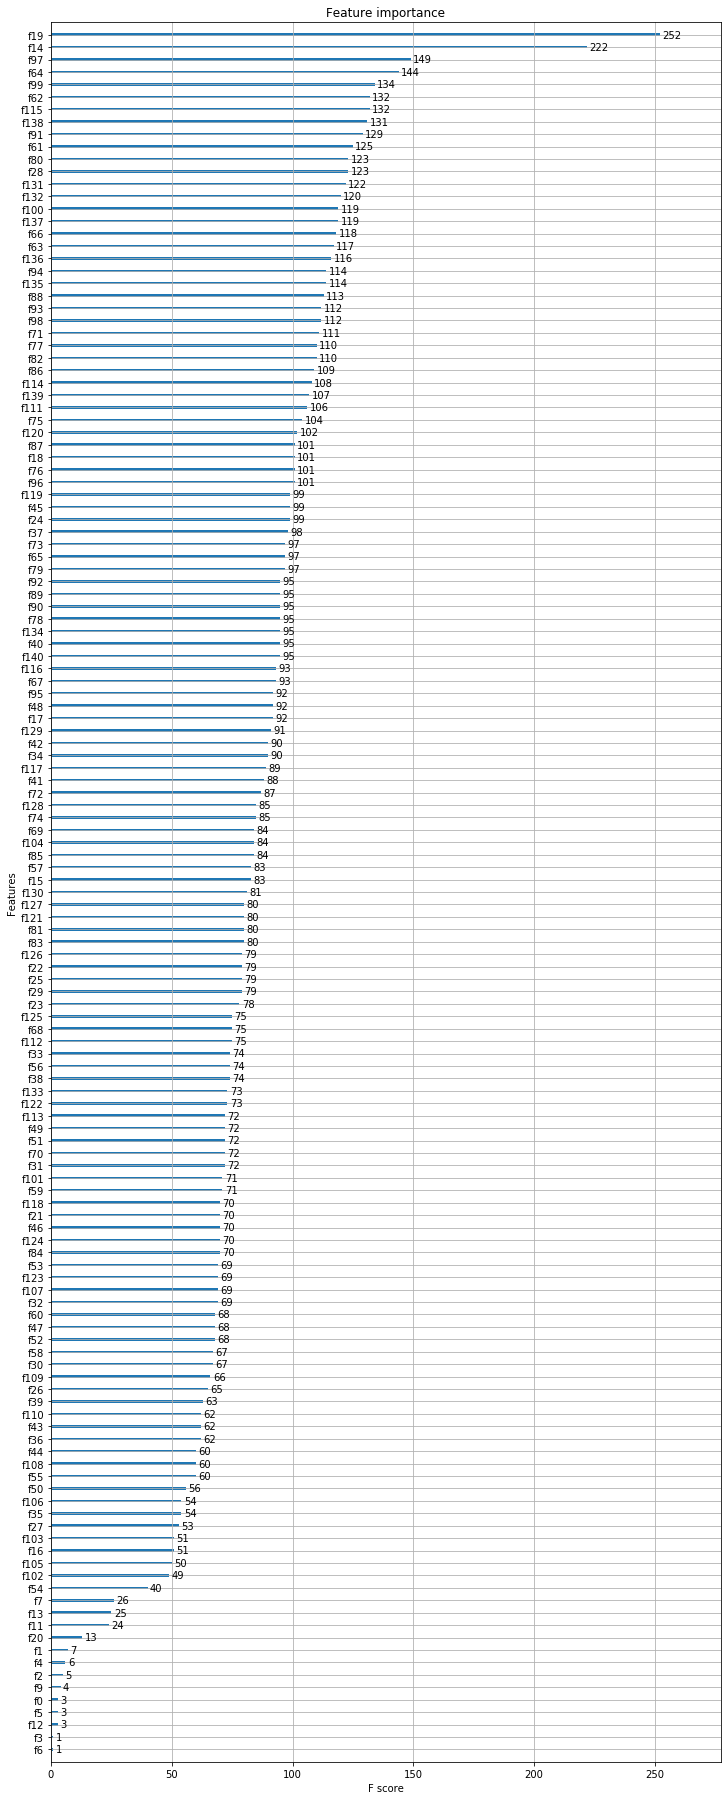

In [40]:
fig, ax = plt.subplots(figsize=(12, 32))
xgb.plot_importance(clf, ax=ax)

Features de poco puntaje: id, keyword, text, text_clean, tags_count, links_count, hastags_count,
                          text_len, stop_word_count, caps_count, caps_ratio, key_global 
                          
Es decir que podemos intentar remover algunas de las features referidas a los counts para ver si mejora el puntaje y luego empezar a trabajar en remover stopwords del texto etc

## Removiendo features 

In [46]:
X_train.drop(['id', 'tags_count', 'links_count', 'hashtags_count', 'text_len', 'stop_word_count',\
             'caps_count', 'caps_ratio'],axis=1,inplace=True)

In [49]:
cat_columns = ['key_global']

num_columns = [
#     'id',
    #'tags_count', 'links_count',
    #'hashtags_count', 'text_len', 
    'word_count',
    #'stop_word_count',
    'punctuation_count'
    #, 'caps_count', 'caps_ratio'
    ]

bool_columns = ['retweet_bool']

text_columns = ['keyword',
                'text',
                'text_clean'
               ]

transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            ("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))


#algoritmo a usar
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
steps.append(("xgb", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  26.8s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=   2.2s
F1 Score: 0.7590820675364929
Precision: 0.7676254479434997
Recall: 0.7554764395462518


El puntaje mejoro para XGBoost pero no para Ridge asi que este analisis de features no es del todo util en general

In [39]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [50]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [51]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  27.6s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=   3.0s


In [52]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [53]:
description = "3 approach. XGBoost_some_feat_select"
save_submission(df_predictions, description=description)

In [45]:
beep()

## K folds en nuestro train set

In [53]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  15.2s
[Pipeline] ................ (step 2 of 2) Processing rc, total=   0.0s
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  15.2s
[Pipeline] ................ (step 2 of 2) Processing rc, total=   0.0s
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  15.1s
[Pipeline] ................ (step 2 of 2) Processing rc, total=   0.0s


***

# Approach 4 - Naive Bayes

## Entrenamiento local

In [144]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

class DenseTransformer():

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

steps.append(("col_trans", my_col_transformer))
steps.append(('to_dense', DenseTransformer()))

#algoritmo a usar
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
steps.append(("nb", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 3) Processing col_trans, total=   1.3s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   0.1s
[Pipeline] ................ (step 3 of 3) Processing nb, total=   0.4s
F1 Score: 0.7535020466161905
Precision: 0.7632702940557501
Recall: 0.7497303747143333


## testeo version final

In [7]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

class DenseTransformer():

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

steps.append(("col_trans", my_col_transformer))
steps.append(('to_dense', DenseTransformer()))

#algoritmo a usar
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
steps.append(("nb", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 3) Processing col_trans, total=   1.3s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   0.1s
[Pipeline] ................ (step 3 of 3) Processing nb, total=   0.3s
F1 Score: 0.7562512371827863
Precision: 0.7636125389223984
Recall: 0.7529558320078917


In [51]:
beep()

## Testeo con nuevos features de texto

In [151]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

class DenseTransformer():

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

steps.append(("col_trans", my_col_transformer))
steps.append(('to_dense', DenseTransformer()))
     
#algoritmo a usar
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
steps.append(("nb", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 3) Processing col_trans, total=   1.3s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   0.1s
[Pipeline] ................ (step 3 of 3) Processing nb, total=   0.5s
F1 Score: 0.7109564900001005
Precision: 0.7115956631117364
Recall: 0.7164241983508783


## Entrenamiento con todos los datos para obtener predicciones a subir

In [8]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [9]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 3) Processing col_trans, total=   1.4s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   0.1s
[Pipeline] ................ (step 3 of 3) Processing nb, total=   0.8s


In [10]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [13]:
description = "4 approach. NaiveBayes_with_new_text_clean_final_no_punct"
save_submission(df_predictions, description=description)

In [159]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 5 - SVM

## Entrenamiento local

In [98]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn import svm
clf = svm.SVC(kernel='linear') # Linear Kernel
steps.append(("svm", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] ............... (step 2 of 2) Processing svm, total=   2.3s
F1 Score: 0.7951850624937558
Precision: 0.8012437607944443
Recall: 0.7918914084161978


In [87]:
beep()

## Testeo con nuevos features de texto

In [153]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn import svm
clf = svm.SVC(kernel='linear') # Linear Kernel
steps.append(("svm", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.4s
[Pipeline] ............... (step 2 of 2) Processing svm, total=   3.0s
F1 Score: 0.79899608990123
Precision: 0.8048636676443667
Recall: 0.7957403741828604


## Entrenamiento con todos los datos para obtener predicciones a subir

In [99]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [100]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing svm, total=   5.0s


In [101]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [102]:
description = "5 approach. SVM"
save_submission(df_predictions, description=description)

In [159]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 6 - KNN

## Entrenamiento local

In [89]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
steps.append(("KNN", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.4s
[Pipeline] ............... (step 2 of 2) Processing KNN, total=   0.0s
F1 Score: 0.6997299666088441
Precision: 0.7008548099338849
Recall: 0.698909897192397


In [87]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [327]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [328]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.2s
[Pipeline] ................ (step 2 of 2) Processing rc, total=   3.9s


In [329]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [330]:
description = "1st approach. RidgeClassifier_hash_vect_no_svd"
save_submission(df_predictions, description=description)

In [159]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 7 - Decision Tree

## Entrenamiento local

In [91]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn import tree
clf = tree.DecisionTreeClassifier()
steps.append(("dt", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.4s
[Pipeline] ................ (step 2 of 2) Processing dt, total=   0.5s
F1 Score: 0.6775086331707996
Precision: 0.6858240232097158
Recall: 0.6753530082015345


In [87]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [327]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [328]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.2s
[Pipeline] ................ (step 2 of 2) Processing rc, total=   3.9s


In [329]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [330]:
description = "1st approach. RidgeClassifier_hash_vect_no_svd"
save_submission(df_predictions, description=description)

In [159]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 8 - Random Forest

## Entrenamiento local

In [104]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
steps.append(("rf", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   2.4s
F1 Score: 0.743627968815304
Precision: 0.7871395873856561
Recall: 0.7382398653947613


In [78]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#Creating a grid of hyperparameters
grid_params = {
    'n_estimators' : [100, 400, 800, 1200, 1600, 2000],
    
    'max_features' : ['auto', 'sqrt'],
   
    # Maximum number of levels in tree
    'max_depth' : [10, 30, 60, 90, 100, None],
    
    # Minimum number of samples required to split a node
    'min_samples_split' : [2, 5, 10],
    
    # Minimum number of samples required at each leaf node
    'min_samples_leaf' : [1, 2, 4],
    
    # Method of selecting samples for training each tree
    'bootstrap' : [True, False]
}

#algoritmo a usar
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

#Building a 3 fold CV GridSearchCV object
crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_object = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'accuracy', cv = crossvalidation, n_jobs = -1)

#Extracting the best parameters
steps.append(("gridsearchcv", grid_object))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

#y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.1s
[Pipeline] ..... (step 2 of 2) Processing gridsearchcv, total=322.6min


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                         

In [79]:
grid_object.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

In [80]:
grid_object.best_score_

0.7858823529411765

In [87]:
beep()

In [83]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=400,bootstrap = False,max_depth = None, max_features = 'auto', \
                             min_samples_leaf = 2, min_samples_split = 2)
steps.append(("rf", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   8.2s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   4.7s
F1 Score: 0.7760587294650061
Precision: 0.8078043160990643
Recall: 0.7692905225415813


## Testeo con nuevos features de texto y sin scaling

In [155]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         #("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
steps.append(("rf", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   2.9s
F1 Score: 0.745157070252277
Precision: 0.7947833413845935
Recall: 0.739677758895366


## Entrenamiento con todos los datos para obtener predicciones a subir

In [84]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [85]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.4s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   8.5s


In [86]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [87]:
description = "8 approach. RandomForest_gridsearch"
save_submission(df_predictions, description=description)

In [159]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 9 - Stochastic Gradient Descent

## Entrenamiento local

In [110]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=600)
steps.append(("SGD", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] ............... (step 2 of 2) Processing SGD, total=   0.0s
F1 Score: 0.7867971446960388
Precision: 0.7877756471716203
Recall: 0.7859716426790901


In [87]:
beep()

## Testeo con nuevos features de texto

In [157]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=600)
steps.append(("SGD", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] ............... (step 2 of 2) Processing SGD, total=   0.0s
F1 Score: 0.7967361705152369
Precision: 0.799984950852653
Recall: 0.7945708096925105


## Entrenamiento con todos los datos para obtener predicciones a subir

In [111]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [112]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing SGD, total=   0.0s


In [113]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [114]:
description = "9 approach. SGD"
save_submission(df_predictions, description=description)

In [159]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 10 - NN MLP 

# Entrenamiento local

In [39]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
steps.append(("MLP", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.2s
[Pipeline] ............... (step 2 of 2) Processing MLP, total=   5.4s
F1 Score: 0.7530747997646954
Precision: 0.7524926873433002
Recall: 0.7537779946878633


In [87]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [40]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [41]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.5s
[Pipeline] ............... (step 2 of 2) Processing MLP, total=  19.5s


In [42]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [43]:
description = "10 approach. NN multi layer perceptron"
save_submission(df_predictions, description=description)

In [159]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Approach 11 - Adaboost

# Entrenamiento local

In [45]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
steps.append(("adaboost", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] .......... (step 2 of 2) Processing adaboost, total=   1.4s
F1 Score: 0.7526139447528739
Precision: 0.7579958404766589
Recall: 0.749889168452286


## Tuning Adaboost con grid search (accuracy)

In [46]:
cat_columns = ['key_global']

num_columns = [
#     'id',
    'tags_count', 'links_count',
    'hashtags_count', 'text_len', 'word_count', 'stop_word_count',
    'punctuation_count', 'caps_count', 'caps_ratio'
    ]

bool_columns = ['retweet_bool']

text_columns = ['keyword',
                'text',
                #'text_clean'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Creating a grid of hyperparameters
grid_params = {
    'n_estimators': [100, 300, 500, 700, 900, 1200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 0.75]
}

clf = AdaBoostClassifier()

#Building a 3 fold CV GridSearchCV object
crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_object = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'accuracy', cv = crossvalidation, n_jobs = -1)

#Extracting the best parameters
steps.append(("gridsearchcv", grid_object))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

#y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.1s
[Pipeline] ...... (step 2 of 2) Processing gridsearchcv, total= 7.9min


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                         

In [47]:
grid_object.best_params_

{'learning_rate': 0.1, 'n_estimators': 900}

In [48]:
grid_object.best_score_

0.7807843137254902

In [50]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Creating a grid of hyperparameters
grid_params = {
    'n_estimators': [800, 850, 900, 950, 1000],
    'learning_rate': [0.05, 0.1, 0.15]
}

clf = AdaBoostClassifier()

#Building a 3 fold CV GridSearchCV object
crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_object = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'accuracy', cv = crossvalidation, n_jobs = -1)

#Extracting the best parameters
steps.append(("gridsearchcv", grid_object))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

#y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.1s
[Pipeline] ...... (step 2 of 2) Processing gridsearchcv, total= 4.8min


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                         

In [51]:
grid_object.best_params_

{'learning_rate': 0.1, 'n_estimators': 900}

In [52]:
grid_object.best_score_

0.7807843137254902

In [205]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=900,learning_rate=0.1)
steps.append(("adaboost", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.6s
[Pipeline] .......... (step 2 of 2) Processing adaboost, total=   6.2s
F1 Score: 0.7650299130028693
Precision: 0.7865698086463501
Recall: 0.7594537365786884


## Con best estimators

In [46]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

#BernoulliNB, DecisionTreeClassifier, ExtraTreeClassifier, ExtraTreesClassifier
#MultinomialNB, NuSVC, Perceptron, RandomForestClassifier, RidgeClassifierCV, SGDClassifier, SVC.

#Creating a grid of hyperparameters
grid_params = {
    'base_estimator': [BernoulliNB(), DecisionTreeClassifier(), ExtraTreeClassifier()],
    'n_estimators': [100, 300, 500, 700, 900, 1200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 0.75]
}

clf = AdaBoostClassifier()

#Building a 3 fold CV GridSearchCV object
crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_object = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'accuracy', cv = crossvalidation, n_jobs = -1)

#Extracting the best parameters
steps.append(("gridsearchcv", grid_object))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

#y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.1s
[Pipeline] ..... (step 2 of 2) Processing gridsearchcv, total=138.6min


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                         

In [47]:
grid_object.best_params_

{'base_estimator': ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                     max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, random_state=None,
                     splitter='random'),
 'learning_rate': 0.001,
 'n_estimators': 1200}

In [48]:
grid_object.best_score_

0.7854901960784314

In [51]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

#BernoulliNB, DecisionTreeClassifier, ExtraTreeClassifier, ExtraTreesClassifier
#MultinomialNB, NuSVC, Perceptron, RandomForestClassifier, RidgeClassifierCV, SGDClassifier, SVC.

#Creating a grid of hyperparameters
grid_params = {
    'base_estimator': [ExtraTreeClassifier()],
    'n_estimators': [1100, 1200, 1300, 1500],
    'learning_rate': [0.0005, 0.001, 0.01]
}

clf = AdaBoostClassifier()

#Building a 3 fold CV GridSearchCV object
crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_object = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'accuracy', cv = crossvalidation, n_jobs = -1)

#Extracting the best parameters
steps.append(("gridsearchcv", grid_object))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

#y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.4s
[Pipeline] ...... (step 2 of 2) Processing gridsearchcv, total=16.9min


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                         

In [52]:
grid_object.best_params_

{'base_estimator': ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                     max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, random_state=None,
                     splitter='random'),
 'learning_rate': 0.001,
 'n_estimators': 1200}

In [53]:
grid_object.best_score_

0.7858823529411765

In [39]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier
clf = AdaBoostClassifier(ExtraTreeClassifier(), n_estimators=1200,learning_rate=0.001)
steps.append(("adaboost", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] .......... (step 2 of 2) Processing adaboost, total=  51.8s
F1 Score: 0.7711282740860017
Precision: 0.8016480723854609
Recall: 0.7646498565671256


In [40]:
beep()

## Tuning Adaboost con grid search (f1)

In [41]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Creating a grid of hyperparameters
grid_params = {
    'n_estimators': [100, 300, 500, 700, 900, 1200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 0.75]
}

clf = AdaBoostClassifier()

#Building a 3 fold CV GridSearchCV object
crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_object = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'f1', cv = crossvalidation, n_jobs = -1)

#Extracting the best parameters
steps.append(("gridsearchcv", grid_object))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

#y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.2s
[Pipeline] ...... (step 2 of 2) Processing gridsearchcv, total= 8.1min


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                         

In [44]:
grid_object.best_params_

{'learning_rate': 0.75, 'n_estimators': 500}

In [43]:
grid_object.best_score_

0.712529878689304

In [39]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=500,learning_rate=0.75)
steps.append(("adaboost", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] .......... (step 2 of 2) Processing adaboost, total=   3.3s
F1 Score: 0.7501530572198529
Precision: 0.7532400299903602
Recall: 0.7482510004005491


In [87]:
beep()

## Probando encodings y scalers

F1 Score: 0.7650299130028693 Precision: 0.7865698086463501 
    Recall: 0.7594537365786884

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('target', axis=1), train['target'], test_size=0.33, random_state=seed)

### Ordinal encoding

In [66]:
from sklearn.preprocessing import OrdinalEncoder

In [67]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("oe", OrdinalEncoder()),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=900,learning_rate=0.1)
steps.append(("adaboost", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.3s
[Pipeline] .......... (step 2 of 2) Processing adaboost, total=   7.7s
F1 Score: 0.761269097367265
Precision: 0.7824176421685833
Recall: 0.7558504150025731


Da peor

### MinMaxScaler (Normalization)

In [76]:
from sklearn.preprocessing import MinMaxScaler

In [78]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", MinMaxScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
     
#algoritmo a usar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=900,learning_rate=0.1)
steps.append(("adaboost", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.2s
[Pipeline] .......... (step 2 of 2) Processing adaboost, total=   7.8s
F1 Score: 0.7654045510305874
Precision: 0.7871272660590414
Recall: 0.7597995180448018


Mejora un poco

## Entrenamiento con todos los datos para obtener predicciones a subir

In [79]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [80]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.6s
[Pipeline] .......... (step 2 of 2) Processing adaboost, total=  11.7s


In [81]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [209]:
description = "11 approach. Adaboost with minmaxscaler"
save_submission(df_predictions, description=description)

In [45]:
beep()

## K folds en nuestro train set

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_b"

for train_index, test_index in kf.split(train):
    X = train.drop(['target'], axis=1) #set de datos
    y = train['target'] #target
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2, y_train2)
    y_scores = my_pipe.predict(X_test2)
    
    #print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer + ".csv", index=False, header=True)

***

# Probando simple feature selection 

In [74]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", MinMaxScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

#algoritmo a usar
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.feature_selection import RFE
#clf = RFE(estimator=RandomForestClassifier(n_estimators=100,n_jobs=-1), n_features_to_select=100)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
clf = SelectKBest(chi2, k=130)
steps.append(("selectkbest", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

#y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.4s
[Pipeline] ....... (step 2 of 2) Processing selectkbest, total=   0.0s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                         

In [75]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", MinMaxScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

steps.append(("clf_transf_train", clf))

#steps.append(("clf_transf_test", clf.transformt)))

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)

steps.append(("adaboost", clf_2))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 3) Processing col_trans, total=   1.4s
[Pipeline] .. (step 2 of 3) Processing clf_transf_train, total=   0.0s
[Pipeline] .......... (step 3 of 3) Processing adaboost, total=   0.5s
F1 Score: 0.7108355500569508
Precision: 0.7309586842987048
Recall: 0.7072877251792424


In [ ]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train.drop(['target'], axis=1) #set de datos
y = train['target'] #target

In [77]:
my_pipe.fit(X,y)

# prediciendo valores
predictions = my_pipe.predict(test)

[Pipeline] ......... (step 1 of 3) Processing col_trans, total=   1.5s
[Pipeline] .. (step 2 of 3) Processing clf_transf_train, total=   0.0s
[Pipeline] .......... (step 3 of 3) Processing adaboost, total=   0.6s


In [78]:
df_predictions = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [79]:
description = "Test sacando features"
save_submission(df_predictions, description=description)

In [159]:
beep()

# Probando advanced feature selection 

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('target', axis=1), train['target'], test_size=0.33, random_state=seed)

In [41]:
transformers = []

transformers.append(("cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         #("svd", TruncatedSVD(n_components=4, n_iter=7, random_state=seed))
                     ]),
                     cat_columns))

#transformaciones para los numeros, simple imputer para los misssing values y standard scaler
#tal que la distribución tenga un valor medio 0 y una desviación estándar de 1.
transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.

#hashing vectorizer devuelve una matriz de un texto convertido y la SVD reduce su dimension para poder trabajarlo
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
                            ("tf_idf", TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))),
                            #("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii')),
                            #("svd", TruncatedSVD(n_components=40, n_iter=7, random_state=seed))
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
clf = RFECV(estimator=RandomForestClassifier(n_estimators=100,n_jobs=-1), step=1, cv=5, scoring='f1_weighted')

steps.append(("RFECV", clf))

my_pipe = Pipeline(steps, verbose=True)

my_pipe.fit(X_train, y_train)

y_scores = my_pipe.predict(X_test)

#metrica a utilizar
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#print("F1 Score: " + str(f1_score(y_test, y_scores, average="macro")))
#print("Precision: " + str(precision_score(y_test, y_scores, average="macro")))
#print("Recall: " + str(recall_score(y_test, y_scores, average="macro")))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.2s
[Pipeline] ............ (step 2 of 2) Processing RFECV, total=486.1min


In [194]:
my_pipe.named_steps['col_trans'].transformers_[2][1]#['tf_idf'].get_feature_names()

Pipeline(memory=None,
         steps=[('bool_imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0))],
         verbose=False)

In [44]:
support = my_pipe.named_steps['RFECV'].support_

In [172]:
feature_names_cat = my_pipe.named_steps['col_trans'].transformers_[0][1]['one_hot'].get_feature_names().tolist()

In [141]:
feature_names_keyword_text = my_pipe.named_steps['col_trans'].transformers_[3][1]['tf_idf'].get_feature_names()

In [142]:
feature_names_text_text = my_pipe.named_steps['col_trans'].transformers_[4][1]['tf_idf'].get_feature_names()

In [174]:
feature_names = feature_names_cat + num_columns + bool_columns + feature_names_keyword_text + feature_names_text_text

In [215]:
new_list = [feat for feat in feature_names if feat not in np.array(feature_names)[support].tolist()]

In [218]:
# Save Numpy array
np.save('removed_feat', new_list)

In [183]:
# Save Numpy array
np.save('feature_total_names', feature_names)

In [189]:
# Save Numpy array
np.save('support_RFECV', support.tolist())

In [192]:
# Save Numpy array
np.save('feature_selected_names', np.array(feature_names)[support].tolist())

In [ ]:
beep()

***

# Approach 12 - Simple CNN

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.33, random_state=seed)

## Entrenamiento local

In [82]:
vocab_size = 10000
#embedding_dim = 16
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [68]:
# Convolutional layer 
model = Sequential([
    Embedding(vocab_size, 64, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 128)           41088     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 689,409
Trainable params: 689,409
Non-trainable params: 0
_________________________________________________________________


In [69]:
checkpoint = ModelCheckpoint('model_CNN.h5', monitor='val_loss', save_best_only=True)

num_epochs = 10
history_conv = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint])

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5100 samples, validate on 2513 samples
Epoch 1/10
5100/5100 [==============================] - 2s 299us/step - loss: 0.5997 - accuracy: 0.6596 - val_loss: 0.4531 - val_accuracy: 0.7923
Epoch 2/10
5100/5100 [==============================] - 1s 245us/step - loss: 0.3521 - accuracy: 0.8575 - val_loss: 0.4628 - val_accuracy: 0.7855
Epoch 3/10
5100/5100 [==============================] - 1s 251us/step - loss: 0.2264 - accuracy: 0.9190 - val_loss: 0.5212 - val_accuracy: 0.7915
Epoch 4/10
5100/5100 [==============================] - 1s 259us/step - loss: 0.1572 - accuracy: 0.9455 - val_loss: 0.5860 - val_accuracy: 0.7851
Epoch 5/10
5100/5100 [==============================] - 1s 268us/step - loss: 0.1189 - accuracy: 0.9622 - val_loss: 0.6515 - val_accuracy: 0.7803
Epoch 6/10
5100/5100 [==============================] - 1s 271us/step - loss: 0.0940 - accuracy: 0.9692 - val_loss: 0.7225 - val_accuracy: 0.7676
Epoch 7/10
5100/5100 [==============================] - 1s 263us/step - loss

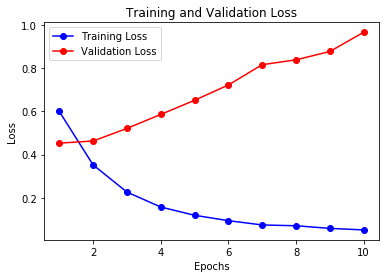

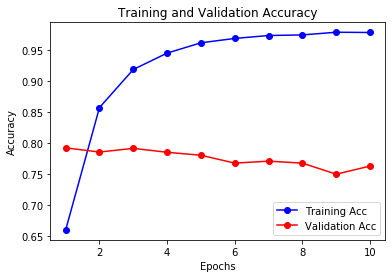

In [70]:
result_eva(history_conv.history['loss'], history_conv.history['val_loss'], history_conv.history['accuracy'], history_conv.history['val_accuracy'])

## CNN + GloVe

In [96]:
vocab_size = 20000
#embedding_dim = 16
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [97]:
embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.300d.txt', encoding="utf8")

In [98]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [99]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [100]:
# Convolutional layer 
model = Sequential([
    #Embedding(vocab_size, 64, input_length=max_length),
    Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_length, \
                         trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 300)           6000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 128)           192128    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 6,200,449
Trainable params: 200,449
Non-trainable params: 6,000,000
_________________________________________________________________


In [101]:
checkpoint = ModelCheckpoint('model_CNN_glove.h5', monitor='val_loss', save_best_only=True)

num_epochs = 3
history_conv = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint])

Train on 5100 samples, validate on 2513 samples
Epoch 1/3
5100/5100 [==============================] - 2s 313us/step - loss: 0.5079 - accuracy: 0.7739 - val_loss: 0.4502 - val_accuracy: 0.8098
Epoch 2/3
5100/5100 [==============================] - 2s 311us/step - loss: 0.4303 - accuracy: 0.8127 - val_loss: 0.4351 - val_accuracy: 0.8102
Epoch 3/3
5100/5100 [==============================] - 2s 315us/step - loss: 0.3944 - accuracy: 0.8306 - val_loss: 0.4230 - val_accuracy: 0.8138


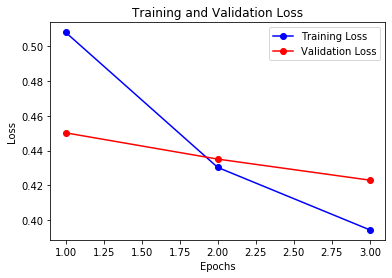

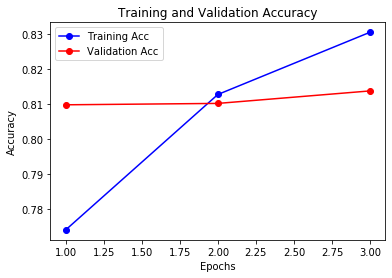

In [102]:
result_eva(history_conv.history['loss'], history_conv.history['val_loss'], history_conv.history['accuracy'], history_conv.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train['text'] #set de datos
y = train['target'] #target

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [ ]:
train_input = tokenizer.texts_to_sequences(X)

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [103]:
test_input = tokenizer.texts_to_sequences(test['text'])

# Padding
testing_input_padded = pad_sequences(test_input, maxlen=max_length)

In [ ]:
model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

In [104]:
model.load_weights('model_CNN_glove.h5')
test_pred = model.predict(testing_input_padded)

In [105]:
df_predictions = pd.DataFrame(data={'id':test['id']})

In [106]:
df_predictions['target'] = test_pred.round().astype(int)

In [107]:
description = "12 approach. Simple CNN_gloVe"
save_submission(df_predictions, description=description)

In [159]:
beep()

***

# Approach 13 - LSTM

## Comun

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.33, random_state=seed)

## Entrenamiento local

In [96]:
vocab_size = 10000
embedding_dim = 16
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [97]:
model = Sequential([
    Embedding(vocab_size, 64),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 677,249
Trainable params: 677,249
Non-trainable params: 0
_________________________________________________________________


In [74]:
checkpoint = ModelCheckpoint('model_LSTM_comun.h5', monitor='val_loss', save_best_only=True)

num_epochs = 10
history_lstm = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint])

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5100 samples, validate on 2513 samples
Epoch 1/10
5100/5100 [==============================] - 4s 690us/step - loss: 0.5706 - accuracy: 0.7065 - val_loss: 0.4792 - val_accuracy: 0.7788
Epoch 2/10
5100/5100 [==============================] - 3s 635us/step - loss: 0.3064 - accuracy: 0.8776 - val_loss: 0.4818 - val_accuracy: 0.7788
Epoch 3/10
5100/5100 [==============================] - 3s 623us/step - loss: 0.1835 - accuracy: 0.9339 - val_loss: 0.6126 - val_accuracy: 0.7788
Epoch 4/10
5100/5100 [==============================] - 3s 598us/step - loss: 0.1241 - accuracy: 0.9567 - val_loss: 0.6650 - val_accuracy: 0.7569
Epoch 5/10
5100/5100 [==============================] - 3s 606us/step - loss: 0.0833 - accuracy: 0.9692 - val_loss: 0.8026 - val_accuracy: 0.7608
Epoch 6/10
5100/5100 [==============================] - 3s 617us/step - loss: 0.0608 - accuracy: 0.9759 - val_loss: 1.0635 - val_accuracy: 0.7501
Epoch 7/10
5100/5100 [==============================] - 3s 627us/step - loss

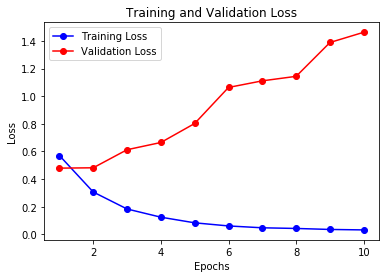

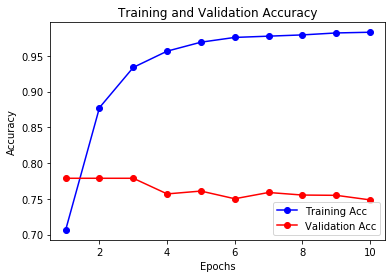

In [75]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train['text'] #set de datos
y = train['target'] #target

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [ ]:
train_input = tokenizer.texts_to_sequences(X)

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [68]:
test_input = tokenizer.texts_to_sequences(test['text'])

# Padding
testing_input_padded = pad_sequences(test_input, maxlen=max_length)

In [ ]:
model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

In [69]:
model.load_weights('model_LSTM_comun.h5')
test_pred = model.predict(testing_input_padded)

In [70]:
df_predictions = pd.DataFrame(data={'id':test['id']})

In [71]:
df_predictions['target'] = test_pred.round().astype(int)

In [72]:
description = "13 approach. LSTM comun"
save_submission(df_predictions, description=description)

In [73]:
beep()

# Modificaciones sobre LSTM

## Entrenamiento local

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.33, random_state=seed)

In [134]:
vocab_size = 20000
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [135]:
embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.300d.txt', encoding="utf8")

In [136]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [137]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [138]:
from keras.regularizers import l2

In [139]:
model = Sequential([
    #Embedding(vocab_size, 64),
    Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_length, \
                         trainable=False),
    Dropout(0.2),
    LSTM(64,return_sequences = True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    LSTM(64,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 300)           6000000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 64)            93440     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 6,130,689
Trainable params: 130,689
Non-trainable params: 6,000,000
______________________________________

In [140]:
checkpoint = ModelCheckpoint('model_LSTM_comun_modif_1.h5', monitor='val_loss', save_best_only=True)

num_epochs = 30
history_lstm = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint])

Train on 5100 samples, validate on 2513 samples
Epoch 1/30
5100/5100 [==============================] - 6s 1ms/step - loss: 3.0875 - accuracy: 0.7543 - val_loss: 1.6070 - val_accuracy: 0.8042
Epoch 2/30
5100/5100 [==============================] - 10s 2ms/step - loss: 1.3749 - accuracy: 0.7882 - val_loss: 1.1742 - val_accuracy: 0.8142
Epoch 3/30
5100/5100 [==============================] - 9s 2ms/step - loss: 1.0764 - accuracy: 0.7851 - val_loss: 0.9415 - val_accuracy: 0.8118
Epoch 4/30
5100/5100 [==============================] - 8s 2ms/step - loss: 0.8805 - accuracy: 0.7914 - val_loss: 0.7918 - val_accuracy: 0.8114
Epoch 5/30
5100/5100 [==============================] - 10s 2ms/step - loss: 0.7467 - accuracy: 0.7955 - val_loss: 0.6819 - val_accuracy: 0.8118
Epoch 6/30
5100/5100 [==============================] - 6s 1ms/step - loss: 0.6587 - accuracy: 0.7949 - val_loss: 0.6118 - val_accuracy: 0.8110
Epoch 7/30
5100/5100 [==============================] - 9s 2ms/step - loss: 0.6027 - a

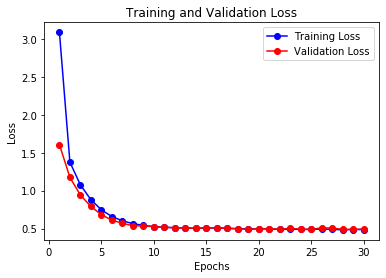

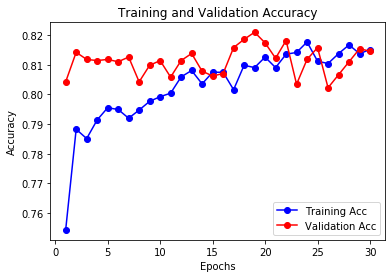

In [141]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train['text'] #set de datos
y = train['target'] #target

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [ ]:
train_input = tokenizer.texts_to_sequences(X)

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [142]:
test_input = tokenizer.texts_to_sequences(test['text'])

# Padding
testing_input_padded = pad_sequences(test_input, maxlen=max_length)

In [ ]:
model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

In [143]:
model.load_weights('model_LSTM_comun_modif_1.h5')
test_pred = model.predict(testing_input_padded)

In [144]:
df_predictions = pd.DataFrame(data={'id':test['id']})

In [145]:
df_predictions['target'] = test_pred.round().astype(int)

In [146]:
description = "13 approach. LSTM_comun_modif_1_reg_30epoc"
save_submission(df_predictions, description=description)

In [73]:
beep()

# Regularizer test

## Entrenamiento local

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.33, random_state=seed)

In [204]:
vocab_size = 30000
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [205]:
embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.300d.txt', encoding="utf8")

In [206]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [207]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## L1 y L1L2 no sirven, dan malos accuracies

## grid search

In [133]:
# grid search values
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_train, all_test = list(), list()
for param in values:
    # define model
    model = Sequential([
        #Embedding(vocab_size, 64),
        Embedding(vocab_size, embedding_dim, \
                             weights=[embedding_matrix], \
                             input_length=max_length, \
                             trainable=False),
        Dropout(0.2),
        LSTM(64,return_sequences = True, kernel_regularizer=l2(param), recurrent_regularizer=l2(param), bias_regularizer=l2(param)),
        LSTM(64,kernel_regularizer=l2(param), recurrent_regularizer=l2(param), bias_regularizer=l2(param)),
        #Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(param), bias_regularizer=l2(param)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    num_epochs = 10
    model.fit(padded, y_train, epochs=num_epochs)#, validation_data=(testing_padded, y_test),callbacks=[checkpoint])
    # evaluate the model
    _, train_acc = model.evaluate(padded, y_train, verbose=0)
    _, test_acc = model.evaluate(testing_padded, y_test, verbose=0)
    #print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)

Epoch 1/10
5100/5100 [==============================] - 5s 965us/step - loss: 24.6912 - accuracy: 0.5673
Epoch 2/10
5100/5100 [==============================] - 4s 852us/step - loss: 8.5864 - accuracy: 0.5678
Epoch 3/10
5100/5100 [==============================] - 4s 854us/step - loss: 5.9335 - accuracy: 0.5678
Epoch 4/10
5100/5100 [==============================] - 4s 867us/step - loss: 4.1313 - accuracy: 0.5678
Epoch 5/10
5100/5100 [==============================] - 4s 865us/step - loss: 2.8570 - accuracy: 0.5678
Epoch 6/10
5100/5100 [==============================] - 4s 846us/step - loss: 1.9904 - accuracy: 0.5678
Epoch 7/10
5100/5100 [==============================] - 4s 847us/step - loss: 1.4287 - accuracy: 0.5678
Epoch 8/10
5100/5100 [==============================] - 4s 848us/step - loss: 1.0837 - accuracy: 0.5678
Epoch 9/10
5100/5100 [==============================] - 4s 845us/step - loss: 0.8848 - accuracy: 0.5678
Epoch 10/10
5100/5100 [==============================] - 4s 847

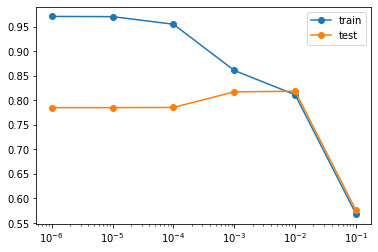

In [134]:
from matplotlib import pyplot
# plot train and test means
pyplot.semilogx(values, all_train, label='train', marker='o')
pyplot.semilogx(values, all_test, label='test', marker='o')
pyplot.legend()
pyplot.show()

## conviene entre 10 -4 y 10 -2 entonces, habra que probar

In [78]:
reg_value = 0.01
model = Sequential([
    Embedding(vocab_size, 300),
    #Embedding(vocab_size, embedding_dim, \
    #                     weights=[embedding_matrix], \
    #                     input_length=max_length, \
    #                     trainable=False),
    Dropout(0.2),
    #LSTM(128,return_sequences = True, kernel_regularizer=l2(reg_value), recurrent_regularizer=l2(reg_value), bias_regularizer=l2(reg_value)),
    LSTM(64, kernel_regularizer=l2(reg_value), recurrent_regularizer=l2(reg_value), bias_regularizer=l2(reg_value)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(reg_value), bias_regularizer=l2(reg_value)),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         9000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 9,097,665
Trainable params: 9,097,665
Non-trainable params: 0
____________________________________________

In [79]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
checkpoint = ModelCheckpoint('model_LSTM_comun_modif_reg_e4_3epc.h5', monitor='val_loss', verbose=1, save_best_only=True)

num_epochs = 20
history_lstm = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint,es])

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5100 samples, validate on 2513 samples
Epoch 1/20
5100/5100 [==============================] - 17s 3ms/step - loss: 2.1093 - accuracy: 0.6390 - val_loss: 1.0726 - val_accuracy: 0.7887

Epoch 00001: val_loss improved from inf to 1.07260, saving model to model_LSTM_comun_modif_reg_e4_3epc.h5
Epoch 2/20
5100/5100 [==============================] - 16s 3ms/step - loss: 0.8275 - accuracy: 0.8625 - val_loss: 0.8494 - val_accuracy: 0.7791

Epoch 00002: val_loss improved from 1.07260 to 0.84937, saving model to model_LSTM_comun_modif_reg_e4_3epc.h5
Epoch 3/20
5100/5100 [==============================] - 16s 3ms/step - loss: 0.5364 - accuracy: 0.9355 - val_loss: 0.7926 - val_accuracy: 0.7736

Epoch 00003: val_loss improved from 0.84937 to 0.79260, saving model to model_LSTM_comun_modif_reg_e4_3epc.h5
Epoch 4/20
5100/5100 [==============================] - 16s 3ms/step - loss: 0.3799 - accuracy: 0.9627 - val_loss: 0.7658 - val_accuracy: 0.7692

Epoch 00004: val_loss improved from 0.7926

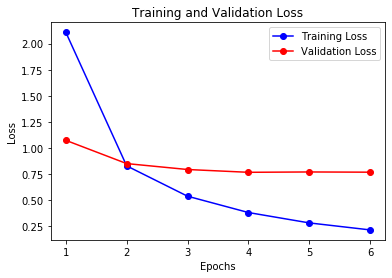

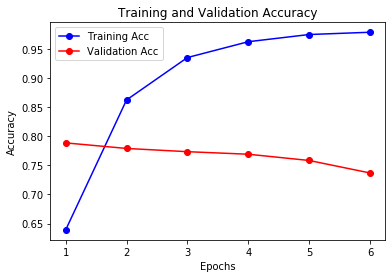

In [80]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

### 10 -4

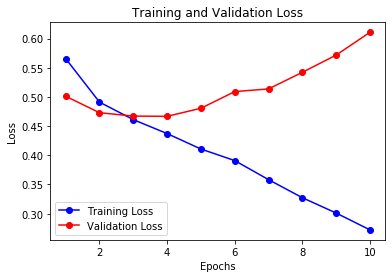

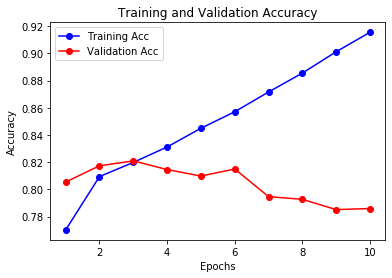

In [74]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

3 epochs

### 10 -3

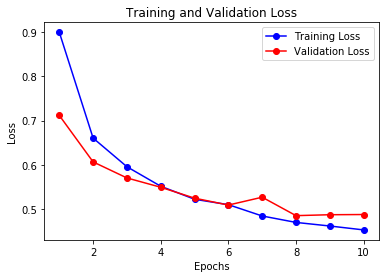

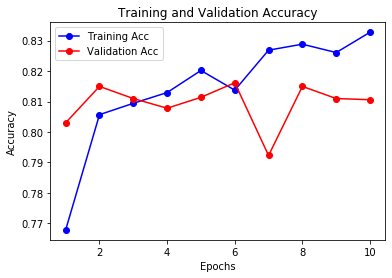

In [79]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

Hasta 6 epochs podria funcionar

### 10 -2

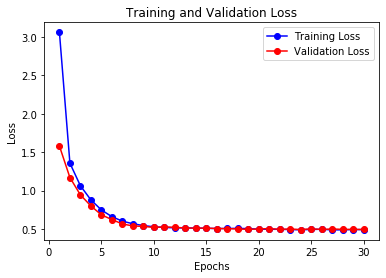

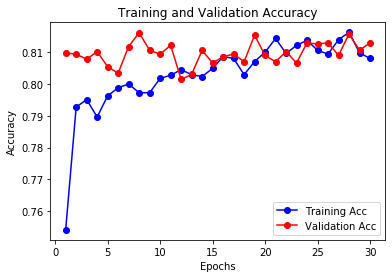

In [92]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

Habria que testear epochs, esto es medio extranio

## Entrenamiento con todos los datos para obtener predicciones a subir

In [255]:
train = pd.read_csv('train_final.csv')
test = pd.read_csv('test_final.csv')

In [256]:
X = train['text'] #set de datos
y = train['target'] #target

In [257]:
vocab_size = 30000
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [258]:
reg_value = 0.0001
model = Sequential([
    Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_length, \
                         trainable=False),
    Dropout(0.2),
    LSTM(64,return_sequences = True, kernel_regularizer=l2(reg_value), recurrent_regularizer=l2(reg_value), bias_regularizer=l2(reg_value)),
    LSTM(64, kernel_regularizer=l2(reg_value), recurrent_regularizer=l2(reg_value), bias_regularizer=l2(reg_value)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(reg_value), bias_regularizer=l2(reg_value)),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 300)           9000000   
_________________________________________________________________
dropout_24 (Dropout)         (None, 50, 300)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 50, 64)            93440     
_________________________________________________________________
lstm_31 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 1)               

In [259]:
train_input = tokenizer.texts_to_sequences(X)

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [260]:
test_input = tokenizer.texts_to_sequences(test['text'])

# Padding
testing_input_padded = pad_sequences(test_input, maxlen=max_length)

In [261]:
checkpoint = ModelCheckpoint('model_LSTM_comun_reg_10e4_7epc.h5', verbose=1)

num_epochs = 7
history_lstm = model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

Epoch 1/7
7613/7613 [==============================] - 7s 955us/step - loss: 0.6919 - accuracy: 0.6371

Epoch 00001: saving model to model_LSTM_comun_reg_10e4_7epc.h5
Epoch 2/7
7613/7613 [==============================] - 7s 881us/step - loss: 0.6081 - accuracy: 0.7139

Epoch 00002: saving model to model_LSTM_comun_reg_10e4_7epc.h5
Epoch 3/7
7613/7613 [==============================] - 7s 946us/step - loss: 0.5535 - accuracy: 0.7577

Epoch 00003: saving model to model_LSTM_comun_reg_10e4_7epc.h5
Epoch 4/7
7613/7613 [==============================] - 7s 978us/step - loss: 0.5078 - accuracy: 0.7917

Epoch 00004: saving model to model_LSTM_comun_reg_10e4_7epc.h5
Epoch 5/7
7613/7613 [==============================] - 8s 1ms/step - loss: 0.4678 - accuracy: 0.8175

Epoch 00005: saving model to model_LSTM_comun_reg_10e4_7epc.h5
Epoch 6/7
7613/7613 [==============================] - 8s 1ms/step - loss: 0.4325 - accuracy: 0.8409

Epoch 00006: saving model to model_LSTM_comun_reg_10e4_7epc.h5
Ep

In [262]:
model.load_weights('model_LSTM_comun_reg_10e4_7epc.h5')
test_pred = model.predict(testing_input_padded)

In [263]:
df_predictions = pd.DataFrame(data={'id':test['id']})

In [264]:
df_predictions['target'] = test_pred.round().astype(int)

In [265]:
description = "13 approach. LSTM_comun_modif_reg_10e-4_7epoc"
save_submission(df_predictions, description=description)

In [73]:
beep()

# Testeo con 3 epochs

## Entrenamiento local

In [156]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.33, random_state=seed)

In [157]:
vocab_size = 20000
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [158]:
embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.300d.txt', encoding="utf8")

In [159]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [160]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [167]:
model = Sequential([
    #Embedding(vocab_size, 64),
    Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_length, \
                         trainable=False),
    Dropout(0.2),
    
#GlobalAveragePooling1D(),
    
    #model_glove.add(Conv1D(64, 5, activation='relu'))
#model_glove.add(MaxPooling1D(pool_size=4))
    
    LSTM(64,return_sequences = True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           6000000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 64)            93440     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 6,130,689
Trainable params: 130,689
Non-trainable params: 6,000,000
______________________________________

In [73]:
checkpoint = ModelCheckpoint('model_LSTM_comun_test_layers_only_text_3.h5', monitor='val_loss', save_best_only=True)

num_epochs = 3
history_lstm = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint])

Train on 5100 samples, validate on 2513 samples
Epoch 1/3
5100/5100 [==============================] - 7s 1ms/step - loss: 0.5003 - accuracy: 0.7755 - val_loss: 0.4344 - val_accuracy: 0.8162
Epoch 2/3
5100/5100 [==============================] - 5s 975us/step - loss: 0.4300 - accuracy: 0.8063 - val_loss: 0.4171 - val_accuracy: 0.8197
Epoch 3/3
5100/5100 [==============================] - 7s 1ms/step - loss: 0.4023 - accuracy: 0.8239 - val_loss: 0.4127 - val_accuracy: 0.8257


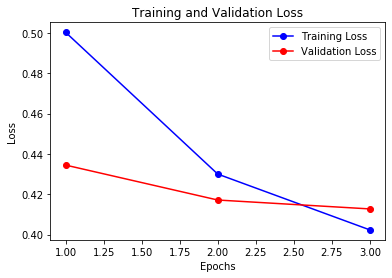

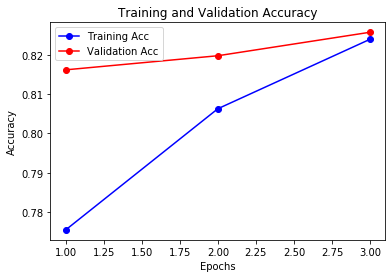

In [74]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [180]:
train = pd.read_csv('train_final.csv')
test = pd.read_csv('test_final.csv')

In [181]:
X = train['text'] #set de datos
y = train['target'] #target

In [182]:
vocab_size = 20000
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"
num_epochs = 3
# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [183]:
model = Sequential([
    #Embedding(vocab_size, 64),
    Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_length, \
                         trainable=False),
    Dropout(0.2),
    LSTM(64,return_sequences = True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 300)           6000000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50, 64)            93440     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 6,130,689
Trainable params: 130,689
Non-trainable params: 6,000,000
______________________________________

In [184]:
train_input = tokenizer.texts_to_sequences(X)

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [185]:
test_input = tokenizer.texts_to_sequences(test['text'])

# Padding
testing_input_padded = pad_sequences(test_input, maxlen=max_length)

In [186]:
checkpoint = ModelCheckpoint('model_LSTM_simple_final.h5', monitor='val_loss')
model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

Epoch 1/3
7613/7613 [==============================] - 7s 944us/step - loss: 0.6317 - accuracy: 0.6376
Epoch 2/3
7613/7613 [==============================] - 7s 876us/step - loss: 0.5511 - accuracy: 0.7222
Epoch 3/3
7613/7613 [==============================] - 10s 1ms/step - loss: 0.4869 - accuracy: 0.7687


In [187]:
model.load_weights('model_LSTM_simple_final.h5')
test_pred = model.predict(testing_input_padded)

In [188]:
df_predictions = pd.DataFrame(data={'id':test['id']})

In [189]:
df_predictions['target'] = test_pred.round().astype(int)

In [190]:
description = "13 approach. LSTM_simple_final"
save_submission(df_predictions, description=description)

In [73]:
beep()

# Last tests

## Entrenamiento local

In [35]:
train = pd.read_csv('train_final.csv')
test = pd.read_csv('test_final.csv')

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.25, random_state=seed)

In [37]:
vocab_size = 20000
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [38]:
embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.300d.txt', encoding="utf8")

In [39]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [40]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [41]:
model = Sequential([
    #Embedding(vocab_size, 64),
    Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_length, \
                         trainable=False),
    Dropout(0.2),
    
#GlobalAveragePooling1D(),
    
    #model_glove.add(Conv1D(64, 5, activation='relu'))
#model_glove.add(MaxPooling1D(pool_size=4))
    
    LSTM(64,return_sequences = True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           6000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 64)            93440     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 6,130,689
Trainable params: 130,689
Non-trainable params: 6,000,000
______________________________________

In [42]:
checkpoint = ModelCheckpoint('model_LSTM_comun_final_test_2.h5', monitor='val_loss', save_best_only=True)

num_epochs = 2
history_lstm = model.fit(padded, y_train, batch_size=16, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint])

Train on 5709 samples, validate on 1904 samples
Epoch 1/2
5709/5709 [==============================] - 9s 2ms/step - loss: 0.4875 - accuracy: 0.7767 - val_loss: 0.4732 - val_accuracy: 0.7862
Epoch 2/2
5709/5709 [==============================] - 8s 1ms/step - loss: 0.4247 - accuracy: 0.8173 - val_loss: 0.4198 - val_accuracy: 0.8230


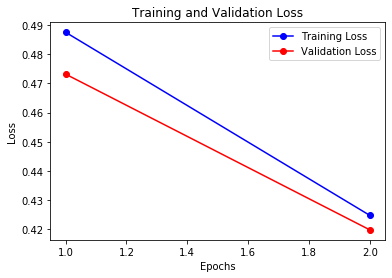

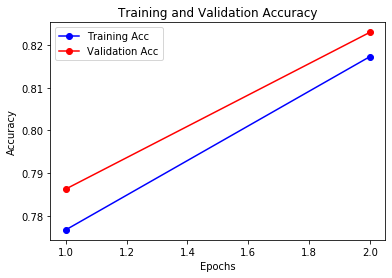

In [43]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [44]:
test_input = tokenizer.texts_to_sequences(test['text'].astype(str))

# Padding
testing_input_padded = pad_sequences(test_input, maxlen=max_length)

In [45]:
model.load_weights('model_LSTM_comun_final_test_2.h5')
test_pred = model.predict(testing_input_padded)

In [46]:
df_predictions = pd.DataFrame(data={'id':test['id']})

In [47]:
df_predictions['target'] = test_pred.round().astype(int)

In [48]:
description = "13 approach. LSTM_simple_final_test_2"
save_submission(df_predictions, description=description)

In [73]:
beep()

# Intentando con ambas features

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[['text','keyword']], train['target'], test_size=0.33, random_state=seed)

In [68]:
vocab_size = 15000
max_length = 50
oov_tok = "<OOV>"
trunc_type='post'

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts((X_train['text']+X_train['keyword']))

word_index = tokenizer.word_index

In [69]:
max_words_t = max([len(x.split()) for x in (X_train.text)]) + 1
max_words_k = max([len(x.split()) for x in (X_train.keyword)]) + 1

print("max_words_t: ", str(max_words_t))
print("max_words_k: ", str(max_words_k))

max_words_t:  50
max_words_k:  4


In [70]:
X_train_seq_t = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq_t = tokenizer.texts_to_sequences(X_test['text'])

# Padding
X_train_pad_t = pad_sequences(X_train_seq_t, maxlen=max_words_t, truncating=trunc_type)
X_test_pad_t = pad_sequences(X_test_seq_t, maxlen=max_words_t)

In [71]:
X_train_seq_k = tokenizer.texts_to_sequences(X_train['keyword'])
X_test_seq_k = tokenizer.texts_to_sequences(X_test['keyword'])

# Padding
X_train_pad_k = pad_sequences(X_train_seq_k, maxlen=max_words_k, truncating=trunc_type)
X_test_pad_k = pad_sequences(X_test_seq_k, maxlen=max_words_k)

In [72]:
# One-hot category
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [73]:
embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.50d.txt', encoding="utf8")

In [74]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [75]:
embedding_dim = 50
embedding_matrix = zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [76]:
input1 = Input(shape=(max_words_t,))

embedding_ly = Embedding(vocab_size, embedding_dim,\
                         weights=[embedding_matrix], \
                         input_length=max_words_t, \
                         trainable=False)(input1)

lstm = LSTM(64)(embedding_ly)

In [77]:
input2 = Input(shape=(max_words_k,))

embedding_ly2 = Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_words_k, \
                         trainable=False)(input2)

lstm2 = LSTM(64)(embedding_ly2)

In [78]:
merge = concatenate([lstm, lstm2])

In [83]:
dense1 = Dense(64, activation='relu')(merge)
output = Dense(2, activation='sigmoid')(dense1)

In [84]:
model_lstm = Model(inputs=[input1,input2], outputs=output)

model_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       750000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 4, 50)        750000      input_2[0][0]                    
____________________________________________________________________________________________

In [85]:
model_lstm.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [86]:
checkpoint = ModelCheckpoint('model_LSTM_bf.h5', monitor='val_loss', save_best_only=True)

history_lstm_bf = model_lstm.fit([X_train_pad_t,X_train_pad_k], y_train, \
                                       validation_data=([X_test_pad_t,X_test_pad_k], y_test), \
                                       epochs=30, callbacks=[checkpoint])

Train on 5100 samples, validate on 2513 samples
Epoch 1/30
5100/5100 [==============================] - 3s 556us/step - loss: 0.4929 - accuracy: 0.7725 - val_loss: 0.4498 - val_accuracy: 0.7986
Epoch 2/30
5100/5100 [==============================] - 2s 452us/step - loss: 0.4307 - accuracy: 0.8077 - val_loss: 0.4512 - val_accuracy: 0.7994
Epoch 3/30
5100/5100 [==============================] - 2s 473us/step - loss: 0.4141 - accuracy: 0.8228 - val_loss: 0.4240 - val_accuracy: 0.8199
Epoch 4/30
5100/5100 [==============================] - 2s 466us/step - loss: 0.3989 - accuracy: 0.8265 - val_loss: 0.4375 - val_accuracy: 0.8100
Epoch 5/30
5100/5100 [==============================] - 2s 472us/step - loss: 0.3852 - accuracy: 0.8375 - val_loss: 0.4285 - val_accuracy: 0.8162
Epoch 6/30
5100/5100 [==============================] - 2s 479us/step - loss: 0.3649 - accuracy: 0.8443 - val_loss: 0.4295 - val_accuracy: 0.8130
Epoch 7/30
5100/5100 [==============================] - 2s 475us/step - loss

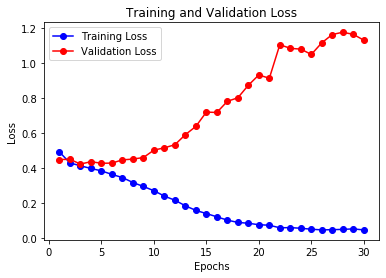

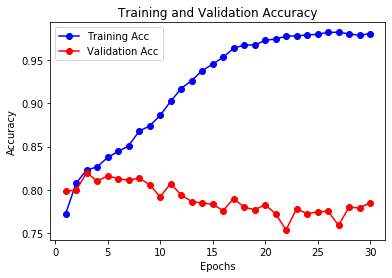

In [88]:
result_eva(history_lstm_bf.history['loss'], history_lstm_bf.history['val_loss'], history_lstm_bf.history['accuracy'], history_lstm_bf.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train['text','keyword'] #set de datos
y = train['target'] #target

In [ ]:
train_input = tokenizer.texts_to_sequences(X['text'])

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [ ]:
train_input_k = tokenizer.texts_to_sequences(X['keyword'])

# Padding
train_input_padded_k = pad_sequences(train_input_k, maxlen=max_length)

In [89]:
test_seq_t = tokenizer.texts_to_sequences(test['text'])
test_pad_t = pad_sequences(test_seq_t, maxlen=max_words_t, truncating=trunc_type)

In [90]:
test_seq_k = tokenizer.texts_to_sequences(test['keyword'])
test_pad_k = pad_sequences(test_seq_k, maxlen=max_words_k, truncating=trunc_type)

In [ ]:
model.fit([train_input_padded,train_input_padded_k],y,epochs=num_epochs, callbacks=[checkpoint])

In [91]:
model_lstm.load_weights('model_LSTM_bf.h5')
test_pred = model_lstm.predict([test_pad_t,test_pad_k])

In [92]:
test_pred_argmax = np.argmax(test_pred,axis=1)

In [100]:
#test_pred_mean_round = np.mean(test_pred,axis=1).round().astype(int)

In [103]:
#df_predictions_mean = pd.DataFrame(data={'id':test['id']})

In [104]:
#df_predictions_mean['target'] = test_pred_mean_round

In [93]:
df_predictions_argmax = pd.DataFrame(data={'id':test['id']})

In [94]:
df_predictions_argmax['target'] = test_pred_argmax

In [95]:
description = "13 approach. LSTM bf argmax_2"
save_submission(df_predictions_argmax, description=description)

In [73]:
beep()

### El promedio no da buenos resultados

## Bidireccional

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.33, random_state=seed)

## Entrenamiento local

In [77]:
vocab_size = 10000
embedding_dim = 16
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [78]:
model = Sequential([
    Embedding(vocab_size, 64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 64)            640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 751,489
Trainable params: 751,489
Non-trainable params: 0
_________________________________________________________________


In [79]:
checkpoint = ModelCheckpoint('model_LSTM_bidireccional.h5', monitor='val_loss', save_best_only=True)

num_epochs = 10
history_lstm = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint])

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5100 samples, validate on 2513 samples
Epoch 1/10
5100/5100 [==============================] - 8s 2ms/step - loss: 0.5528 - accuracy: 0.7135 - val_loss: 0.4521 - val_accuracy: 0.8014
Epoch 2/10
5100/5100 [==============================] - 6s 1ms/step - loss: 0.3012 - accuracy: 0.8788 - val_loss: 0.4867 - val_accuracy: 0.7867
Epoch 3/10
5100/5100 [==============================] - 6s 1ms/step - loss: 0.1808 - accuracy: 0.9392 - val_loss: 0.5825 - val_accuracy: 0.7660
Epoch 4/10
5100/5100 [==============================] - 6s 1ms/step - loss: 0.1226 - accuracy: 0.9616 - val_loss: 0.6860 - val_accuracy: 0.7461
Epoch 5/10
5100/5100 [==============================] - 7s 1ms/step - loss: 0.0964 - accuracy: 0.9698 - val_loss: 0.6655 - val_accuracy: 0.7533
Epoch 6/10
5100/5100 [==============================] - 7s 1ms/step - loss: 0.0784 - accuracy: 0.9755 - val_loss: 0.9792 - val_accuracy: 0.7533
Epoch 7/10
5100/5100 [==============================] - 7s 1ms/step - loss: 0.0561 - acc

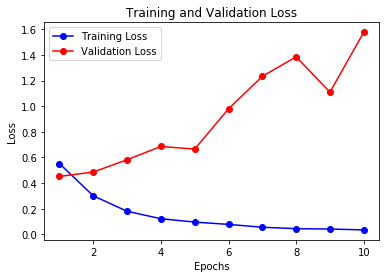

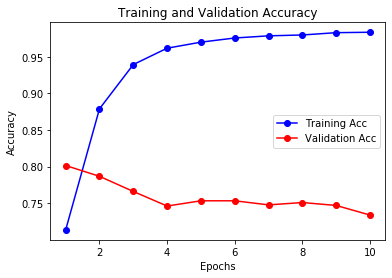

In [80]:
result_eva(history_lstm.history['loss'], history_lstm.history['val_loss'], history_lstm.history['accuracy'], history_lstm.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train['text'] #set de datos
y = train['target'] #target

In [ ]:
train_input = tokenizer.texts_to_sequences(X)

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [70]:
test_input = tokenizer.texts_to_sequences(test['text'])

# Padding
testing_input_padded = pad_sequences(test_input, maxlen=max_length)

In [ ]:
model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

In [71]:
model.load_weights('model_LSTM_bidireccional.h5')
test_pred = model.predict(testing_input_padded)

In [72]:
df_predictions = pd.DataFrame(data={'id':test['id']})

In [73]:
df_predictions['target'] = test_pred.round().astype(int)

In [74]:
description = "13 approach. LSTM bidireccional"
save_submission(df_predictions, description=description)

In [75]:
beep()

***

# Intentando con mas capas, embedding, etc... pruebas

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[['text','keyword']], train['target'], test_size=0.33, random_state=seed)

In [68]:
vocab_size = 50000
max_length = 50
oov_tok = "<OOV>"
trunc_type='post'

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts((X_train['text']+X_train['keyword']))

word_index = tokenizer.word_index

In [69]:
max_words_t = max([len(x.split()) for x in (X_train.text)]) + 1
max_words_k = max([len(x.split()) for x in (X_train.keyword)]) + 1

print("max_words_t: ", str(max_words_t))
print("max_words_k: ", str(max_words_k))

max_words_t:  50
max_words_k:  6


In [70]:
X_train_seq_t = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq_t = tokenizer.texts_to_sequences(X_test['text'])

# Padding
X_train_pad_t = pad_sequences(X_train_seq_t, maxlen=max_words_t, truncating=trunc_type)
X_test_pad_t = pad_sequences(X_test_seq_t, maxlen=max_words_t)

In [71]:
X_train_seq_k = tokenizer.texts_to_sequences(X_train['keyword'])
X_test_seq_k = tokenizer.texts_to_sequences(X_test['keyword'])

# Padding
X_train_pad_k = pad_sequences(X_train_seq_k, maxlen=max_words_k, truncating=trunc_type)
X_test_pad_k = pad_sequences(X_test_seq_k, maxlen=max_words_k)

In [72]:
# One-hot category
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [73]:
embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.300d.txt', encoding="utf8")

In [74]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [75]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [78]:
input1 = Input(shape=(max_words_t,))

embedding_ly1 = Embedding(vocab_size, embedding_dim,\
                         weights=[embedding_matrix], \
                         input_length=max_words_t, \
                         trainable=False)(input1)

dropout1 = Dropout(0.2)(embedding_ly1)
lstm1_1 = LSTM(128,return_sequences = True)(dropout1)
lstm1_2 = LSTM(128)(lstm1_1)

In [79]:
input2 = Input(shape=(max_words_k,))

embedding_ly2 = Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_words_k, \
                         trainable=False)(input2)

dropout2 = Dropout(0.2)(embedding_ly2)
#model_glove.add(Conv1D(64, 5, activation='relu'))
#model_glove.add(MaxPooling1D(pool_size=4))
lstm2_1 = LSTM(64,return_sequences = True)(dropout2)
lstm2_2 = LSTM(64)(lstm2_1)

In [80]:
merge = concatenate([lstm1_2, lstm2_2])

In [81]:
dropout = Dropout(0.2)(merge)
dense1 = Dense(256, activation='relu')(dropout)
dense2 = Dense(128, activation='relu')(dense1)
output = Dense(2, activation='sigmoid')(dense2)

In [82]:
model = Model(inputs=[input1,input2], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      15000000    input_2[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 6, 300)       15000000    input_3[0][0]                    
____________________________________________________________________________________________

In [83]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [84]:
checkpoint = ModelCheckpoint('model_testing_layers.h5', monitor='val_loss', save_best_only=True)

history = model.fit([X_train_pad_t,X_train_pad_k], y_train, \
                        validation_data=([X_test_pad_t,X_test_pad_k], y_test), \
                        epochs=20, batch_size = 64, callbacks=[checkpoint])

Train on 5100 samples, validate on 2513 samples
Epoch 1/20
5100/5100 [==============================] - 8s 2ms/step - loss: 0.5034 - accuracy: 0.7669 - val_loss: 0.4371 - val_accuracy: 0.8150
Epoch 2/20
5100/5100 [==============================] - 7s 1ms/step - loss: 0.4221 - accuracy: 0.8158 - val_loss: 0.4162 - val_accuracy: 0.8259
Epoch 3/20
5100/5100 [==============================] - 8s 2ms/step - loss: 0.4051 - accuracy: 0.8280 - val_loss: 0.4211 - val_accuracy: 0.8233
Epoch 4/20
5100/5100 [==============================] - 8s 2ms/step - loss: 0.3692 - accuracy: 0.8362 - val_loss: 0.4369 - val_accuracy: 0.8120
Epoch 5/20
5100/5100 [==============================] - 8s 2ms/step - loss: 0.3392 - accuracy: 0.8514 - val_loss: 0.4370 - val_accuracy: 0.8269
Epoch 6/20
5100/5100 [==============================] - 8s 2ms/step - loss: 0.3147 - accuracy: 0.8626 - val_loss: 0.4346 - val_accuracy: 0.8265
Epoch 7/20
5100/5100 [==============================] - 8s 2ms/step - loss: 0.2916 - acc

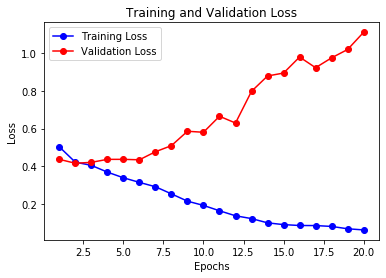

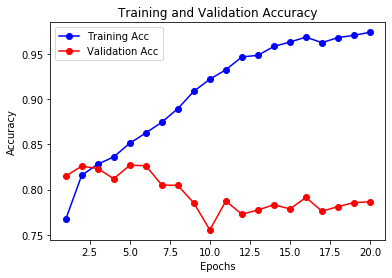

In [86]:
result_eva(history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train['text','keyword'] #set de datos
y = train['target'] #target

In [ ]:
train_input = tokenizer.texts_to_sequences(X['text'])

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [ ]:
train_input_k = tokenizer.texts_to_sequences(X['keyword'])

# Padding
train_input_padded_k = pad_sequences(train_input_k, maxlen=max_length)

In [87]:
test_seq_t = tokenizer.texts_to_sequences(test['text'])
test_pad_t = pad_sequences(test_seq_t, maxlen=max_words_t, truncating=trunc_type)

In [88]:
test_seq_k = tokenizer.texts_to_sequences(test['keyword'])
test_pad_k = pad_sequences(test_seq_k, maxlen=max_words_k, truncating=trunc_type)

In [ ]:
model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

In [90]:
model.load_weights('model_testing_layers.h5')
test_pred = model.predict([test_pad_t,test_pad_k])

In [91]:
test_pred_argmax = np.argmax(test_pred,axis=1)

In [100]:
#test_pred_mean_round = np.mean(test_pred,axis=1).round().astype(int)

In [103]:
#df_predictions_mean = pd.DataFrame(data={'id':test['id']})

In [104]:
#df_predictions_mean['target'] = test_pred_mean_round

In [92]:
df_predictions_argmax = pd.DataFrame(data={'id':test['id']})

In [93]:
df_predictions_argmax['target'] = test_pred_argmax

In [94]:
description = "13 approach. LSTM testing layers"
save_submission(df_predictions_argmax, description=description)

In [73]:
beep()

# Intentando menos epochs

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[['text','keyword']], train['target'], test_size=0.33, random_state=seed)

In [68]:
vocab_size = 20000
max_length = 50
oov_tok = "<OOV>"
trunc_type='post'

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts((X_train['text']+X_train['keyword']))

word_index = tokenizer.word_index

In [69]:
max_words_t = max([len(x.split()) for x in (X_train.text)]) + 1
max_words_k = max([len(x.split()) for x in (X_train.keyword)]) + 1

print("max_words_t: ", str(max_words_t))
print("max_words_k: ", str(max_words_k))

max_words_t:  50
max_words_k:  6


In [70]:
X_train_seq_t = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq_t = tokenizer.texts_to_sequences(X_test['text'])

# Padding
X_train_pad_t = pad_sequences(X_train_seq_t, maxlen=max_words_t, truncating=trunc_type)
X_test_pad_t = pad_sequences(X_test_seq_t, maxlen=max_words_t)

In [71]:
X_train_seq_k = tokenizer.texts_to_sequences(X_train['keyword'])
X_test_seq_k = tokenizer.texts_to_sequences(X_test['keyword'])

# Padding
X_train_pad_k = pad_sequences(X_train_seq_k, maxlen=max_words_k, truncating=trunc_type)
X_test_pad_k = pad_sequences(X_test_seq_k, maxlen=max_words_k)

In [72]:
# One-hot category
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [73]:
embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.300d.txt', encoding="utf8")

In [74]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [75]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [76]:
reg_value = 0.01

In [77]:
input1 = Input(shape=(max_words_t,))

embedding_ly1 = Embedding(vocab_size, embedding_dim,\
                         weights=[embedding_matrix], \
                         input_length=max_words_t, \
                         trainable=False)(input1)

dropout1 = Dropout(0.2)(embedding_ly1)
lstm1_1 = LSTM(64,return_sequences = True,kernel_regularizer=l2(reg_value), recurrent_regularizer=l2(reg_value), bias_regularizer=l2(reg_value))(dropout1)
lstm1_2 = LSTM(64,kernel_regularizer=l2(reg_value), recurrent_regularizer=l2(reg_value), bias_regularizer=l2(reg_value))(lstm1_1)

In [78]:
input2 = Input(shape=(max_words_k,))

embedding_ly2 = Embedding(vocab_size, embedding_dim, \
                         weights=[embedding_matrix], \
                         input_length=max_words_k, \
                         trainable=False)(input2)

dropout2 = Dropout(0.2)(embedding_ly2)
#model_glove.add(Conv1D(64, 5, activation='relu'))
#model_glove.add(MaxPooling1D(pool_size=4))
lstm2_1 = LSTM(64,return_sequences = True,kernel_regularizer=l2(reg_value), recurrent_regularizer=l2(reg_value), bias_regularizer=l2(reg_value))(dropout2)
lstm2_2 = LSTM(64,kernel_regularizer=l2(reg_value), recurrent_regularizer=l2(reg_value), bias_regularizer=l2(reg_value))(lstm2_1)

In [79]:
merge = concatenate([lstm1_2, lstm2_2])

In [84]:
dropout = Dropout(0.2)(merge)
dense1 = Dense(64, activation='relu')(dropout)
output = Dense(2, activation='sigmoid')(dense1)

In [85]:
model = Model(inputs=[input1,input2], outputs=output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      6000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 6, 300)       6000000     input_2[0][0]                    
____________________________________________________________________________________________

In [86]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [87]:
checkpoint = ModelCheckpoint('model_testing_layers_less_epochs.h5', monitor='val_loss', save_best_only=True)

history = model.fit([X_train_pad_t,X_train_pad_k], y_train, \
                        validation_data=([X_test_pad_t,X_test_pad_k], y_test), \
                        epochs=10, callbacks=[checkpoint])

Train on 5100 samples, validate on 2513 samples
Epoch 1/10
5100/5100 [==============================] - 7s 1ms/step - loss: 4.9439 - accuracy: 0.7489 - val_loss: 2.4140 - val_accuracy: 0.8050
Epoch 2/10
5100/5100 [==============================] - 6s 1ms/step - loss: 2.0752 - accuracy: 0.7893 - val_loss: 1.7540 - val_accuracy: 0.8126
Epoch 3/10
5100/5100 [==============================] - 5s 1ms/step - loss: 1.5531 - accuracy: 0.7888 - val_loss: 1.3388 - val_accuracy: 0.8142
Epoch 4/10
5100/5100 [==============================] - 6s 1ms/step - loss: 1.1908 - accuracy: 0.7951 - val_loss: 1.0485 - val_accuracy: 0.7935
Epoch 5/10
5100/5100 [==============================] - 5s 1ms/step - loss: 0.9373 - accuracy: 0.7921 - val_loss: 0.8189 - val_accuracy: 0.8078
Epoch 6/10
5100/5100 [==============================] - 5s 1ms/step - loss: 0.7589 - accuracy: 0.7994 - val_loss: 0.6816 - val_accuracy: 0.8092
Epoch 7/10
5100/5100 [==============================] - 6s 1ms/step - loss: 0.6414 - acc

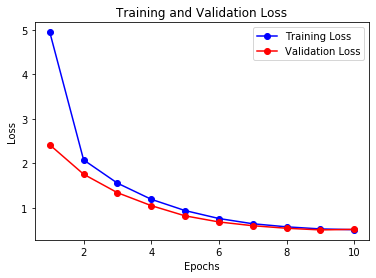

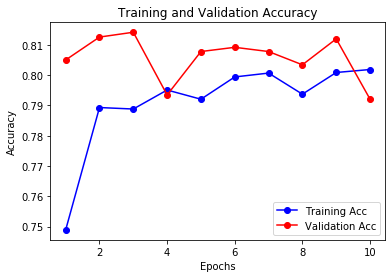

In [88]:
result_eva(history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train['text','keyword'] #set de datos
y = train['target'] #target

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [ ]:
train_input = tokenizer.texts_to_sequences(X['text'])

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [ ]:
train_input_k = tokenizer.texts_to_sequences(X['keyword'])

# Padding
train_input_padded_k = pad_sequences(train_input_k, maxlen=max_length)

In [89]:
test_seq_t = tokenizer.texts_to_sequences(test['text'])
test_pad_t = pad_sequences(test_seq_t, maxlen=max_words_t, truncating=trunc_type)

In [90]:
test_seq_k = tokenizer.texts_to_sequences(test['keyword'])
test_pad_k = pad_sequences(test_seq_k, maxlen=max_words_k, truncating=trunc_type)

In [ ]:
model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

In [91]:
model.load_weights('model_testing_layers_less_epochs.h5')
test_pred = model.predict([test_pad_t,test_pad_k])

In [92]:
test_pred_argmax = np.argmax(test_pred,axis=1)

In [93]:
#test_pred_mean_round = np.mean(test_pred,axis=1).round().astype(int)

In [94]:
#df_predictions_mean = pd.DataFrame(data={'id':test['id']})

In [95]:
#df_predictions_mean['target'] = test_pred_mean_round

In [96]:
df_predictions_argmax = pd.DataFrame(data={'id':test['id']})

In [97]:
df_predictions_argmax['target'] = test_pred_argmax

In [98]:
description = "13 approach. LSTM both features 10ep best simple model params"
save_submission(df_predictions_argmax, description=description)

In [73]:
beep()

***

# Approach 14 - GRU

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.33, random_state=seed)

## Entrenamiento local

In [82]:
vocab_size = 10000
embedding_dim = 16
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [85]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(GRU(32)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                9408      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 7         
Total params: 169,805
Trainable params: 169,805
Non-trainable params: 0
_________________________________________________________________


In [86]:
checkpoint = ModelCheckpoint('model_GRU.h5', monitor='val_loss', save_best_only=True)

num_epochs = 10
history_gru = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),callbacks=[checkpoint])

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5100 samples, validate on 2513 samples
Epoch 1/10
5100/5100 [==============================] - 4s 815us/step - loss: 0.6429 - accuracy: 0.6331 - val_loss: 0.5077 - val_accuracy: 0.7565
Epoch 2/10
5100/5100 [==============================] - 4s 724us/step - loss: 0.3759 - accuracy: 0.8384 - val_loss: 0.4584 - val_accuracy: 0.8046
Epoch 3/10
5100/5100 [==============================] - 3s 682us/step - loss: 0.2402 - accuracy: 0.9076 - val_loss: 0.5131 - val_accuracy: 0.7967
Epoch 4/10
5100/5100 [==============================] - 3s 665us/step - loss: 0.1628 - accuracy: 0.9443 - val_loss: 0.6083 - val_accuracy: 0.7589
Epoch 5/10
5100/5100 [==============================] - 3s 653us/step - loss: 0.1185 - accuracy: 0.9622 - val_loss: 0.6629 - val_accuracy: 0.7624
Epoch 6/10
5100/5100 [==============================] - 3s 656us/step - loss: 0.0921 - accuracy: 0.9712 - val_loss: 0.7258 - val_accuracy: 0.7449
Epoch 7/10
5100/5100 [==============================] - 3s 670us/step - loss

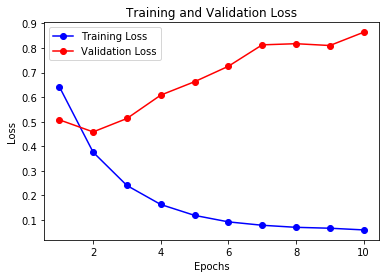

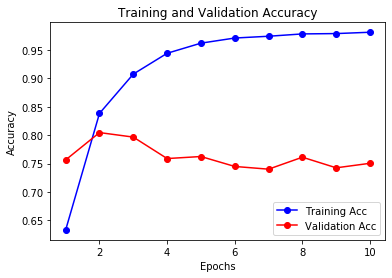

In [87]:
result_eva(history_gru.history['loss'], history_gru.history['val_loss'], history_gru.history['accuracy'], history_gru.history['val_accuracy'])

## Entrenamiento con todos los datos para obtener predicciones a subir

In [76]:
X = train['text'] #set de datos
y = train['target'] #target

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [ ]:
train_input = tokenizer.texts_to_sequences(X)

# Padding
train_input_padded = pad_sequences(train_input, maxlen=max_length)

In [74]:
test_input = tokenizer.texts_to_sequences(test['text'])

# Padding
testing_input_padded = pad_sequences(test_input, maxlen=max_length)

In [ ]:
model.fit(train_input_padded,y,epochs=num_epochs, callbacks=[checkpoint])

In [75]:
model.load_weights('model_GRU.h5')
test_pred = model.predict(testing_input_padded)

In [76]:
df_predictions = pd.DataFrame(data={'id':test['id']})

In [77]:
df_predictions['target'] = test_pred.round().astype(int)

In [78]:
description = "14 approach. GRU"
save_submission(df_predictions, description=description)

In [ ]:
beep()

***

# Approach 15 - BERT

## Corrido en Kaggle porque pide muchos recursos

### Link: https://www.kaggle.com/fcozza/kernel1da79fc81a